In [1]:
import torch, os
import matplotlib.pyplot as plt
import numpy as np
import cv2
import pandas as pd
from scipy.interpolate import interp1d
import random
from scipy import interpolate

### Get GT hyperspectral reflectance

Text(0.5, 0, 'wavelength [nm]')

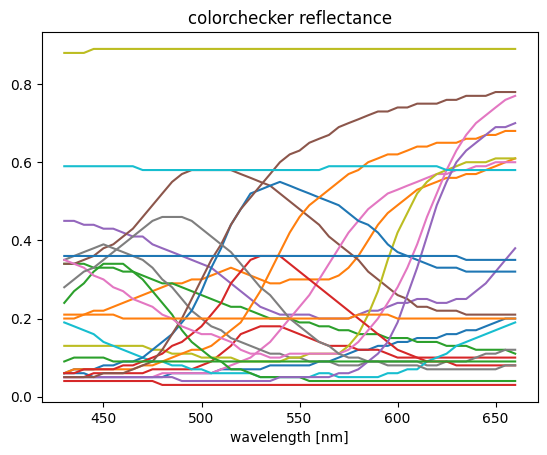

In [2]:
# Replace 'file.csv' with the path to your CSV file
file_path = '../../dataset/MacbethColorChecker.csv'
# Read the CSV file and store it as a DataFrame
df = pd.read_csv(file_path, header=None, skiprows=2)

# Display the DataFrame
wvls_CC = df.values[1:,0]
wvls_CC = [float(x) for x in wvls_CC] 
ref_CC = df.values[1:,1:-2]

ind_min = 6
ind_max = 61

# 420nm - 660nm 10nm interval
# wvls_CC = wvls_CC[ind_min:ind_max:2][1:-2]
# ref_CC = ref_CC[ind_min:ind_max:2,:][1:-2]

# 430nm - 660nm 5nm interval
wvls_CC = wvls_CC[ind_min:ind_max][4:-4]
ref_CC = ref_CC[ind_min:ind_max,:][4:-4]
ref_CC = ref_CC.astype(np.float16)

# print(wvls_CC, ref_CC)

plt.figure()
plt.plot(wvls_CC, ref_CC)
plt.title('colorchecker reflectance')
plt.xlabel('wavelength [nm]')

In [3]:
# arguments
cam_H, cam_W = 580, 890
wvls = np.arange(430, 670, 10) # 430nm 부터 시작

n_illum = 318
n_patches = 24
n_channel = 3

patch_idx = np.arange(0, 24)
patch_size = 3

In [4]:
# date of datas
date = "0913"

ldr2hdr_dir = "./calibration/ldr2hdr/2023%s/"%date

# center points for all patches 20230913
all_patches_center_pts = np.array([[210, 130], [324,142], [442,142], [558, 147], [680,152], [792,154],
[200,250], [326,253], [440,256], [560, 260], [676,261], [792,267],
[190,366], [318,372], [440,372], [558,376], [676,380], [794,379],
[190,490], [314,496], [436,491], [558,492], [678,495], [800,495]])


### Projector & Camera Response function & Dg efficiency

In [5]:
# bring initial value of PEF and CRF
PEF = np.load('../../dataset/image_formation/CRF_proj.npy')
map_scale = interp1d([PEF.min(), PEF.max()], [0.,1])
PEF = map_scale(PEF).astype(np.float32)
PEF = PEF[3:27] # from 430nm

CRF = np.load('../../dataset/image_formation/CRF.npy')[:,1:].T # from 430nm

dg_intensity = np.load('../../dataset/image_formation/dg_efficiency.npy')[1:] # from 430nm

#### Interpolation for 5nm interval

In [6]:
def cubic_interpolation(x_new, x_points, y_points, n):
    tck = interpolate.splrep(x_points, y_points, k=n)   # Estimate the polynomial of nth degree by using x_points and y_points
    y_new = interpolate.splev(x_new, tck)
    return y_new

# wvls from 430 ~ 660 without 630nm
wvls = np.arange(430, 670, 10)
wvls = torch.tensor(wvls)*1e-9
new_wvls = torch.linspace(430*1e-9, 660*1e-9, 47) # 400 ~ 680 까지 10nm 간격으로

In [7]:
# interpolated CRF for 5nm
CRF_R = cubic_interpolation(new_wvls, wvls, CRF[:,0], 4)
CRF_G = cubic_interpolation(new_wvls, wvls, CRF[:,1], 4)
CRF_B = cubic_interpolation(new_wvls, wvls, CRF[:,2], 4)

# interpolated PEF for 5nm
PEF_R = cubic_interpolation(new_wvls, wvls, PEF[:,0], 4)
PEF_G = cubic_interpolation(new_wvls, wvls, PEF[:,1], 4)
PEF_B = cubic_interpolation(new_wvls, wvls, PEF[:,2], 4)

# interpolated CRF for 5nm
dg_efficiency_R = cubic_interpolation(new_wvls, wvls, dg_intensity[:,0], 4)
dg_efficiency_G = cubic_interpolation(new_wvls, wvls, dg_intensity[:,1], 4)
dg_efficiency_B = cubic_interpolation(new_wvls, wvls, dg_intensity[:,2], 4)

In [8]:
CRF_intp = np.stack((CRF_R, CRF_G, CRF_B))
PEF_intp = np.stack((PEF_R, PEF_G, PEF_B))
dg_intensity_intp = np.stack((dg_efficiency_R, dg_efficiency_G, dg_efficiency_B))

(<AxesSubplot:title={'center':'5nm interpolated DG Efficiency'}>,
 Text(0.5, 1.0, '5nm interpolated DG Efficiency'))

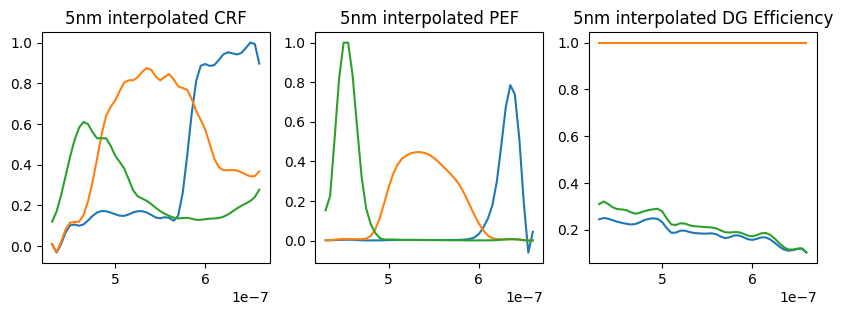

In [9]:
plt.figure(figsize=(10,3))
plt.subplot(131), plt.plot(new_wvls, CRF_intp.T), plt.title('5nm interpolated CRF')
plt.subplot(132), plt.plot(new_wvls, PEF_intp.T), plt.title('5nm interpolated PEF')
plt.subplot(133), plt.plot(new_wvls, dg_intensity_intp.T), plt.title('5nm interpolated DG Efficiency')

### GT RGB Intensity data

In [10]:
# white pattern
white_patt = np.ones(shape = (1, 3))
white_patt_hyp = white_patt @ PEF_intp
white_patt_hyp = white_patt_hyp.squeeze()

In [11]:
# test with GT reflectance for all patches
total_patch = []
for p in range(n_patches):
    I_C = ref_CC[:,p][:,np.newaxis] * CRF_intp.T * white_patt_hyp[:,np.newaxis] * dg_intensity_intp[2][:,np.newaxis]

    total_patch.append(I_C)
total_patch = np.array(total_patch)

In [12]:
# for p in range(n_patches):
#     plt.figure()
#     plt.plot(total_patch[p]), plt.title('%02d patch'%p)

### Real captured RGB Intensity data

In [13]:
hdr_imgs = np.load('../../hdr_step5.npy')

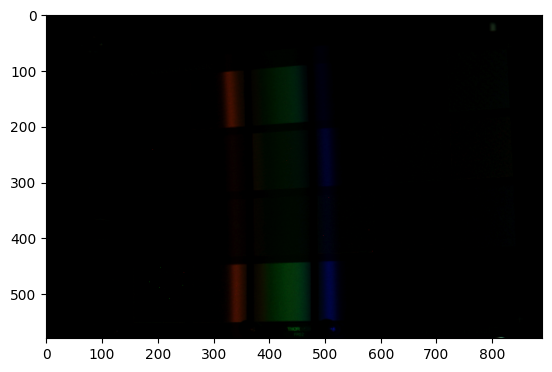

In [14]:
idx = 300
max_val = 65535
plt.imshow(hdr_imgs[idx] / (65535))

In [15]:
final_hdr = hdr_imgs.transpose(1,2,0,3)

### patches rgb real

In [16]:
# plot reflectance for each patches - real
# patches : 24개, wvl : 25 개
patches_rgb_real = np.zeros(shape = (n_illum, n_patches, n_channel))
patches_idx = all_patches_center_pts

cnst = 1
patch_size = 5


# max value defined for each illumination pattern 

for l in range(318):
        y_idx_start, y_idx_end = (patches_idx[:,1] - patch_size//2).astype(np.int32), (patches_idx[:,1] + patch_size//2).astype(np.int32)
        x_idx_start, x_idx_end = (patches_idx[:,0] - patch_size//2).astype(np.int32), (patches_idx[:,0] + patch_size//2).astype(np.int32)
        
        for p in range(n_patches):
                y_idx, x_idx = patches_idx[p,1], patches_idx[p,0]
                rgb_intensity = (final_hdr[y_idx_start[p]:y_idx_end[p], x_idx_start[p]:x_idx_end[p], l] / (65535)).reshape(-1, 3).mean(axis = 0)
                patches_rgb_real[l, p] = rgb_intensity

In [17]:
patches_rgb_real.shape

(318, 24, 3)

#### Visualization

In [18]:
# illum = np.arange(0, 318, 1)

# start_idx = 0
# end_idx = 318

# for p in range(n_patches):
#     fig, ax = plt.subplots()

#     plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, p, 0], label = 'real red', c = 'red'), plt.legend(), plt.ylim(0,1)
#     plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, p, 1], label = 'real green', c = 'green'), plt.legend(), plt.ylim(0,1)
#     plt.plot(illum[start_idx: end_idx], patches_rgb_real[start_idx: end_idx, p, 2], label = 'real blue', c = 'blue'), plt.legend(), plt.ylim(0,1)

#     plt.grid(linestyle = '--')
#     plt.title('RGB intensity %s-th patch'%patch_idx[p])
#     # plt.xlabel('illumination index', fontsize=18)
#     # plt.ylabel('rgb intensity',fontsize=18)
#     # ax.tick_params(axis='both', which='major', labelsize=15)
    
#     # plt.savefig('./%02d-th_patch.png'%(patch_idx[p]))

### Peak Illumination index

#### First orders

In [19]:
# bring peak illumination index
peak_illum_idx = np.load('../../peak_illum_idx.npy') # num patch, wvls (430nm - 660nm except 630nm)

In [20]:
peak_illum_idx[18, 0] = 204

In [21]:
# wvls from 430 ~ 660 without 630nm
wvls = np.arange(430, 670, 10)
wvls = np.delete(wvls, -4)
wvls = torch.tensor(wvls)*1e-9
new_wvls = torch.linspace(430*1e-9, 660*1e-9, 47) # 400 ~ 680 까지 10nm 간격으로

# interpolated index 430 ~ 660 nm for 10nm interval
peak_illum_idx_intp = []
for p in range(n_patches):
    peak_illum_idx_intp.append(cubic_interpolation(new_wvls, wvls, peak_illum_idx[p], 4).astype(np.int16))
peak_illum_idx_intp = np.array(peak_illum_idx_intp)

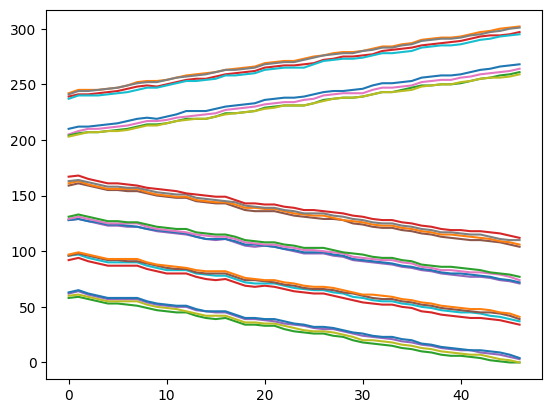

In [22]:
for p in range(n_patches):
    plt.plot(peak_illum_idx_intp[p]) # n_patches, wvls (47, 5nm interval)

In [23]:
peak_illum_idx_intp[17, 0] = 161
peak_illum_idx_intp[17, -1] = 108

peak_illum_idx_intp[15, 0] = 98

peak_illum_idx_intp[12, 0] = 202

peak_illum_idx_intp[11, -1] = 104

#### Zero order

In [24]:
# bring peak illumination index
zero_illum_idx = np.load('../../zero_illum_idx.npy') # num patch, wvls

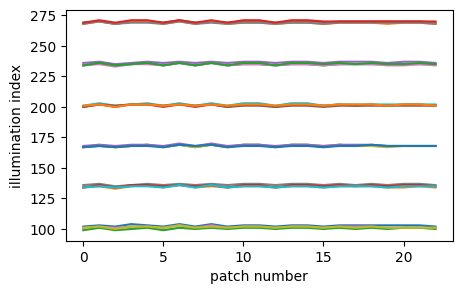

In [25]:
plt.figure(figsize=(5,3))
for p in range(n_patches):
    plt.plot(zero_illum_idx[p]) # zero order index
    plt.xlabel('patch number')
    plt.ylabel('illumination index')

In [26]:
zero_illum_idx_mean = zero_illum_idx.mean(axis = 1)

In [27]:
zero_illum_idx_final = np.zeros(shape=(n_patches, len(wvls)), dtype = np.int16)
for p in range(n_patches):
    zero_illum_idx_final[p,:] = zero_illum_idx_mean[p].astype(np.int16)

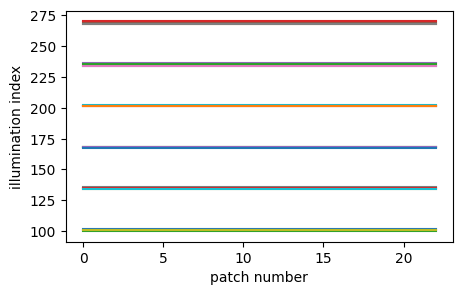

In [28]:
plt.figure(figsize=(5,3))
for p in range(n_patches):
    plt.plot(zero_illum_idx_final[p]) # zero order index
    plt.xlabel('patch number')
    plt.ylabel('illumination index')

### Visualization for only first order dispersed graph

In [29]:
# # for p in range(n_patches):
# for p in range(17,18):
#     plt.figure(figsize = (5,3))
#     plt.ylim([0,1])
#     plt.xlabel('wavelengths 430nm to 660nm')
#     plt.ylabel('RGB intensity')
#     plt.plot(patches_rgb_real[peak_illum_idx_final[p], p]), plt.title('%02d patch'%p)

### Visualization for zero order

In [30]:
# position_430nm = peak_illum_idx_intp[:,0]
# position_660nm = peak_illum_idx_intp[:,-1]

# start_idx = position_430nm
# end_idx = position_660nm

# peak_illum_idx_final = []
# for p in range(n_patches):
#     interval_array = np.linspace(start_idx[p], end_idx[p]+1, 47)
#     interval_array = np.round(interval_array).astype(np.int16)
#     peak_illum_idx_final.append(interval_array)

In [77]:
peak_illum_idx = np.load('../../peak_illum_idx.npy') # num patch, wvls (430nm - 660nm except 630nm)

In [78]:
peak_illum_idx_tmp = peak_illum_idx

In [79]:
peak_illum_idx_tmp[0,-1] = peak_illum_idx[0,-1] + 4

peak_illum_idx_tmp[1,-1] = peak_illum_idx[1,-1] + 2

peak_illum_idx_tmp[2,0] = peak_illum_idx[2,0] + 3
peak_illum_idx_tmp[2,-1] = peak_illum_idx[2,-1] -3

peak_illum_idx_tmp[3,-1] = peak_illum_idx[3,-1] - 4

peak_illum_idx_tmp[4,-1] = peak_illum_idx[4,-1] - 5

peak_illum_idx_tmp[5,-1] = peak_illum_idx[5,-1] - 5

peak_illum_idx_tmp[6,-1] = peak_illum_idx[6,-1] + 3
peak_illum_idx_tmp[6,0] = peak_illum_idx[6,0] + 2

peak_illum_idx_tmp[7,-1] = peak_illum_idx[7,-1] + 4

peak_illum_idx_tmp[8,0] = peak_illum_idx[8,0] + 3

peak_illum_idx_tmp[10,-1] = peak_illum_idx[10,-1] - 4

peak_illum_idx_tmp[11,-1] = peak_illum_idx[11,-1] - 5

peak_illum_idx_tmp[12,-1] = peak_illum_idx[12,-1] + 5

peak_illum_idx_tmp[13,-1] = peak_illum_idx[13,-1] + 3

peak_illum_idx_tmp[15,-1] = peak_illum_idx[15,-1] - 1

peak_illum_idx_tmp[16,-1] = peak_illum_idx[16,-1] - 3

peak_illum_idx_tmp[17,-1] = peak_illum_idx[17,-1] - 4

peak_illum_idx_tmp[18,0] = peak_illum_idx[18,0] + 2
peak_illum_idx_tmp[18,-1] = peak_illum_idx[18,-1] + 6

peak_illum_idx_tmp[19,0] = peak_illum_idx[19,0] - 1
peak_illum_idx_tmp[19,-1] = peak_illum_idx[19,-1] + 5

peak_illum_idx_tmp[20,0] = peak_illum_idx[20,0] + 4

peak_illum_idx_tmp[21,0] = peak_illum_idx[21,0] + 2

In [80]:
peak_illum_idx_final = np.zeros(shape=(24,47), dtype = np.int16)
for i in range(24):
    interval_array = np.linspace(peak_illum_idx_tmp[i,0], peak_illum_idx_tmp[i,-1], 47).T
    interval_array = np.round(interval_array).astype(np.int16)
    peak_illum_idx_final[i] = interval_array
peak_illum_idx_final = np.array(peak_illum_idx_final)

In [81]:
peak_illum_idx_final[peak_illum_idx_final<0] = 0
peak_illum_idx_final[peak_illum_idx_final>317] = 317

In [82]:
# for p in range(n_patches):
#     plt.plot(peak_illum_idx_final[p])

### GT and Simulation plotting

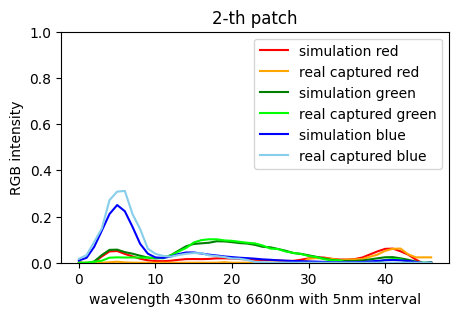

In [83]:
constant = 5
max_ylim = 0.9
patch_num = 2

# plot 1st order rgb intensity for all patches
for p in range(patch_num, patch_num +1): # only visualize white patch
    plt.figure(figsize=(5,3))
    plt.ylim([0, 1])    

    # red
    plt.plot(total_patch[p][:,0] * constant, c = 'red', label = 'simulation red')
    plt.plot(patches_rgb_real[peak_illum_idx_final[p], p][:,0], c = 'orange', label = 'real captured red')
    plt.legend()

    # green
    plt.plot(total_patch[p][:,1]* constant, c = 'green', label = 'simulation green')
    plt.plot(patches_rgb_real[peak_illum_idx_final[p], p][:,1], c = 'lime', label = 'real captured green')
    plt.legend()
    
    # blue
    plt.plot(total_patch[p][:,2]* constant, c = 'blue', label = 'simulation blue')
    plt.plot(patches_rgb_real[peak_illum_idx_final[p], p][:,2], c = 'skyblue', label = 'real captured blue')
    
    plt.xlabel('wavelength 430nm to 660nm with 5nm interval')
    plt.ylabel('RGB intensity')
    plt.title('%s-th patch'%p)
    plt.legend()

In [84]:
efef

NameError: name 'efef' is not defined

### Optimization

PEF, CRF, DG, PEF&CRF, PEF&DG, CRF&DG, PEF&CRF&DG

#### PEF, CRF, DG optimization

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:28: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:38: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch : 0/10000, Loss: 0.004069939594377171, LR: 0.003
Epoch : 500/10000, Loss: 0.0006054848517206582, LR: 0.003
Epoch : 1000/10000, Loss: 0.00031400080346925694, LR: 0.003
Epoch : 1500/10000, Loss: 0.00029853037135167557, LR: 0.003
Epoch : 2000/10000, Loss: 0.0002904265949671919, LR: 0.003
Epoch : 2500/10000, Loss: 0.0002857891165397384, LR: 0.003
Epoch : 3000/10000, Loss: 0.0002830957528203726, LR: 0.003
Epoch : 3500/10000, Loss: 0.0002813870933922854, LR: 0.003
Epoch : 4000/10000, Loss: 0.00028012076985429633, LR: 0.003
Epoch : 4500/10000, Loss: 0.00027904151515527207, LR: 0.003
Epoch : 5000/10000, Loss: 0.00027804305268959564, LR: 0.0015
Epoch : 5500/10000, Loss: 0.00027754191647876394, LR: 0.0015
Epoch : 6000/10000, Loss: 0.00027701912701807237, LR: 0.0015
Epoch : 6500/10000, Loss: 0.0002764867703345689, LR: 0.0015
Epoch : 7000/10000, Loss: 0.0002759584564376961, LR: 0.0015
Epoch : 7500/10000, Loss: 0.0002754466523501006, LR: 0.0015
Epoch : 8000/10000, Loss: 0.0002749594859778881,

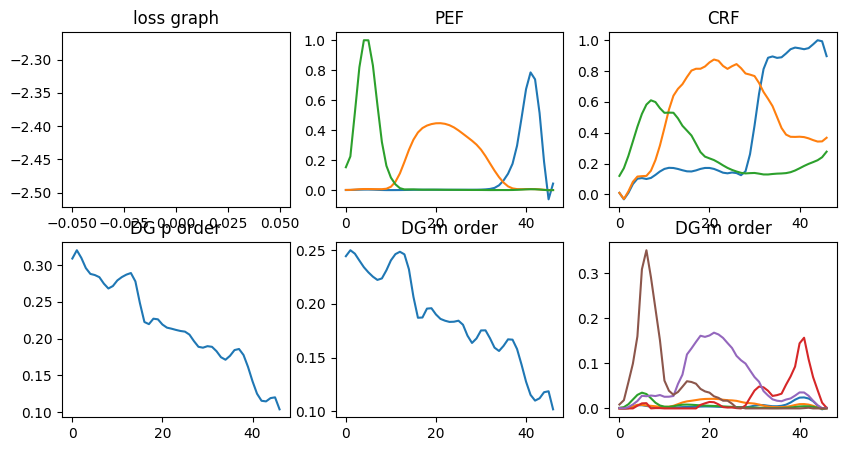

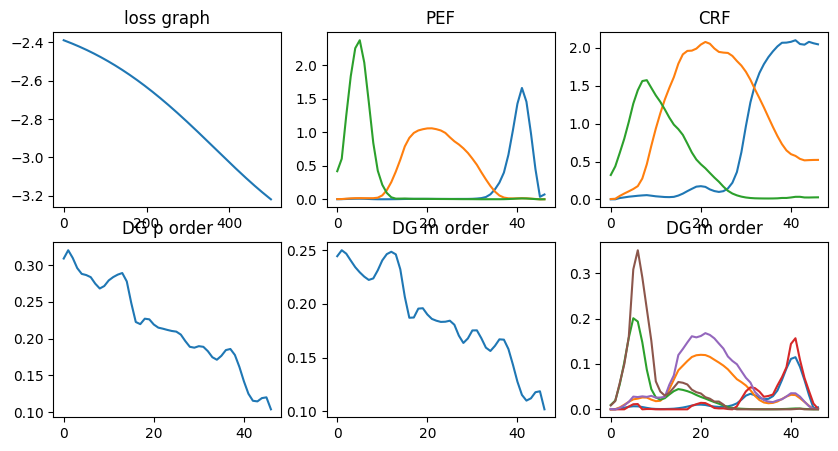

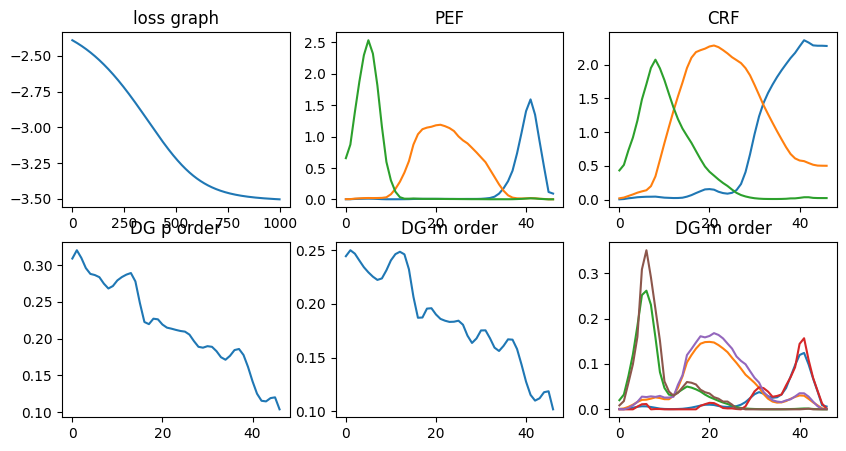

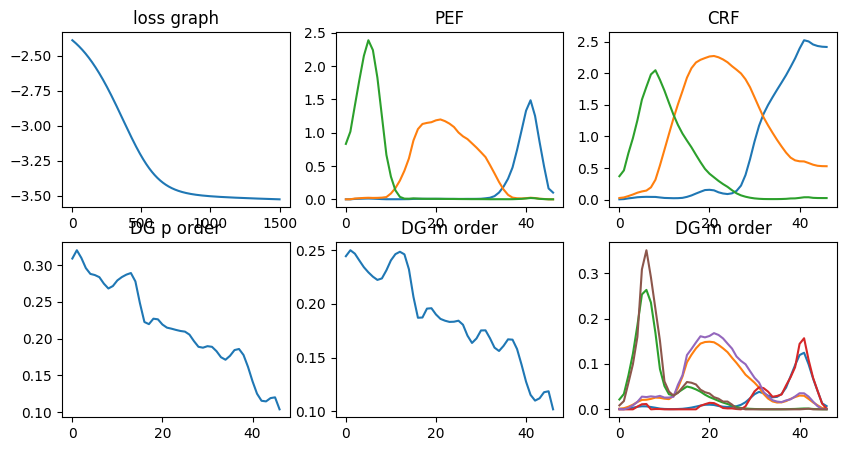

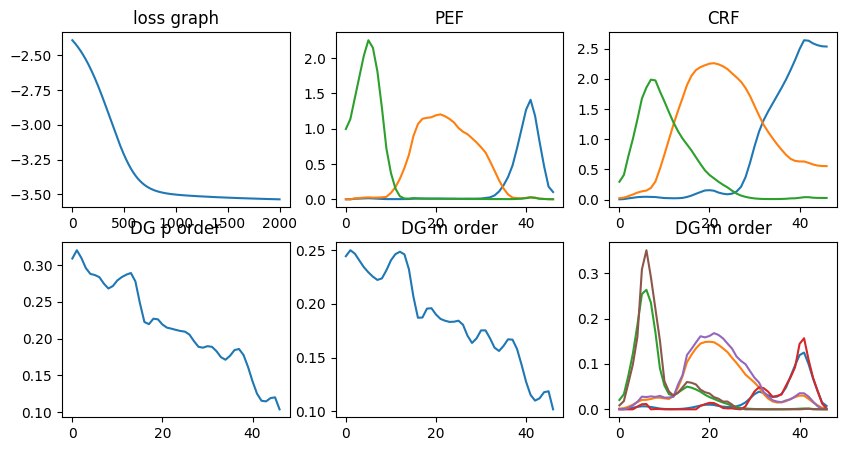

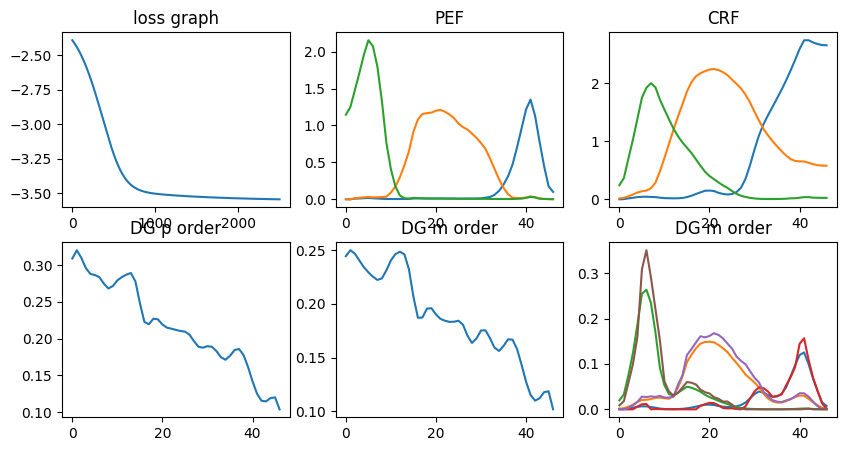

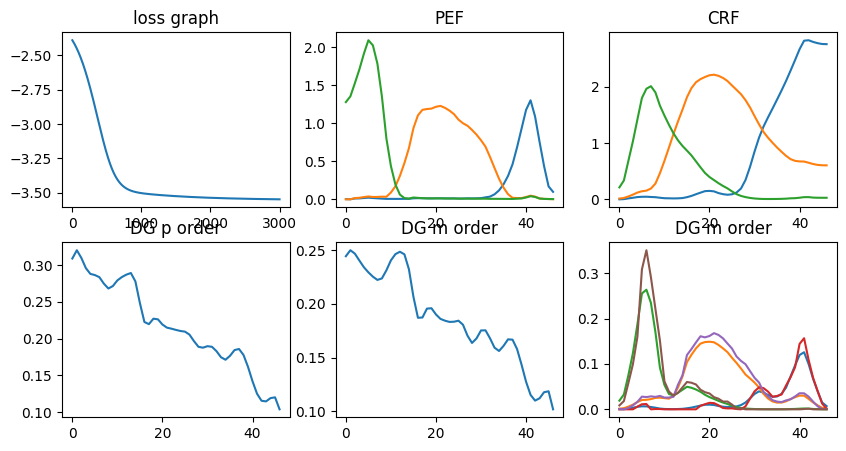

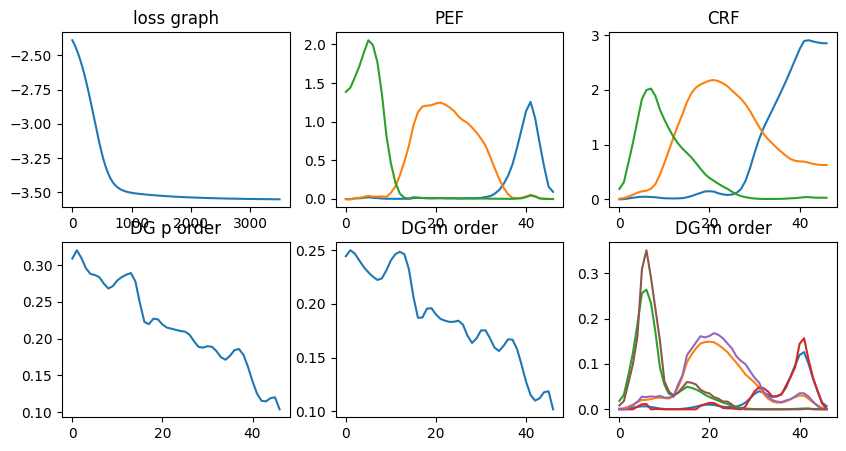

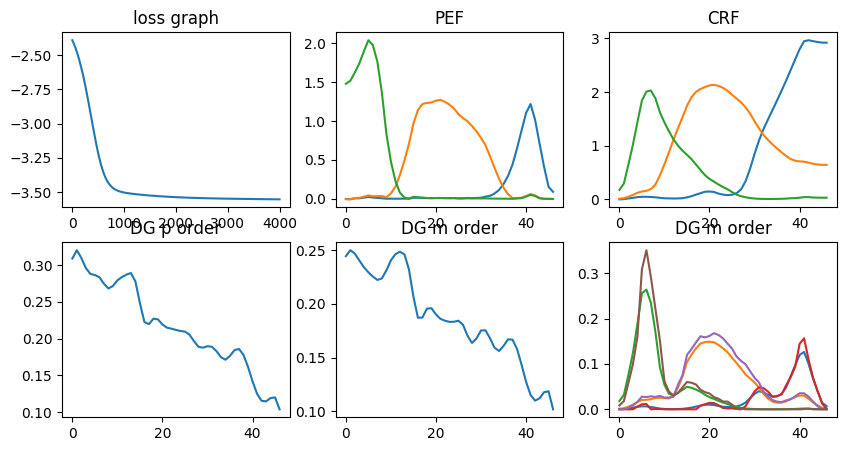

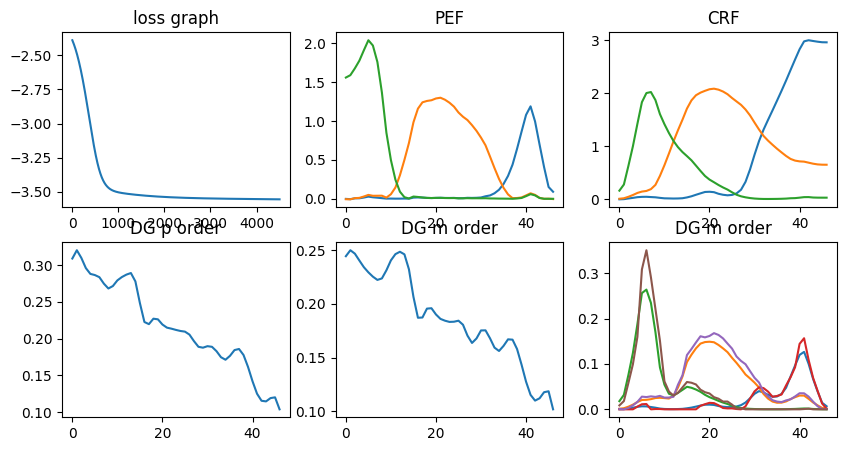

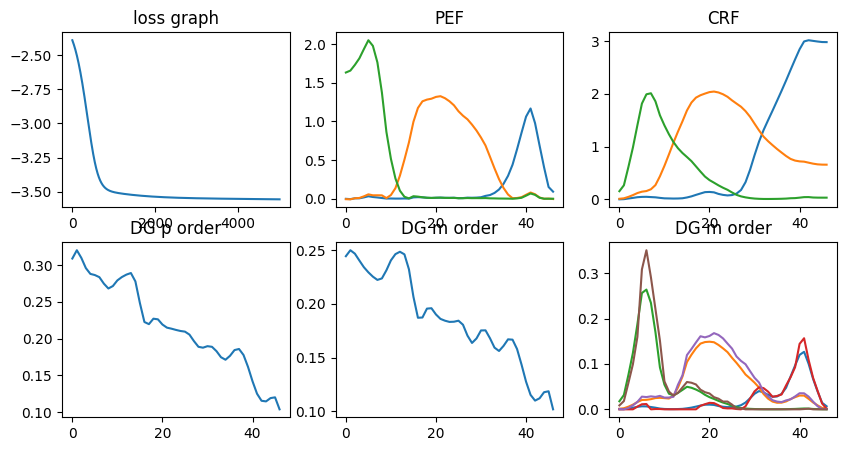

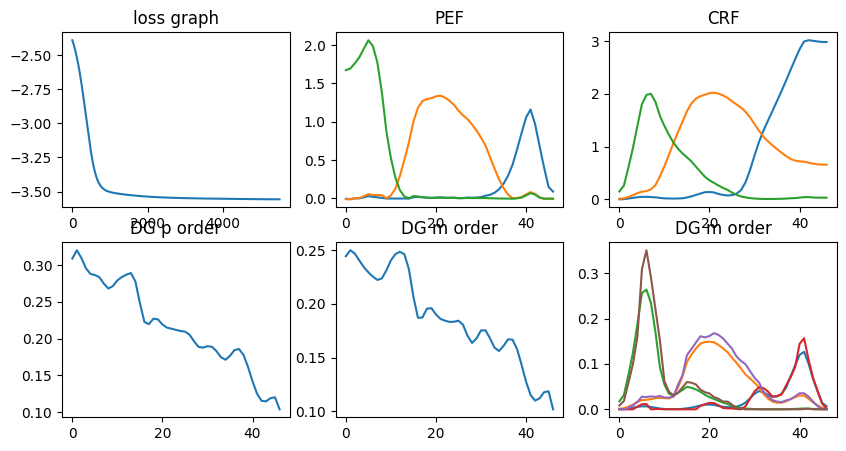

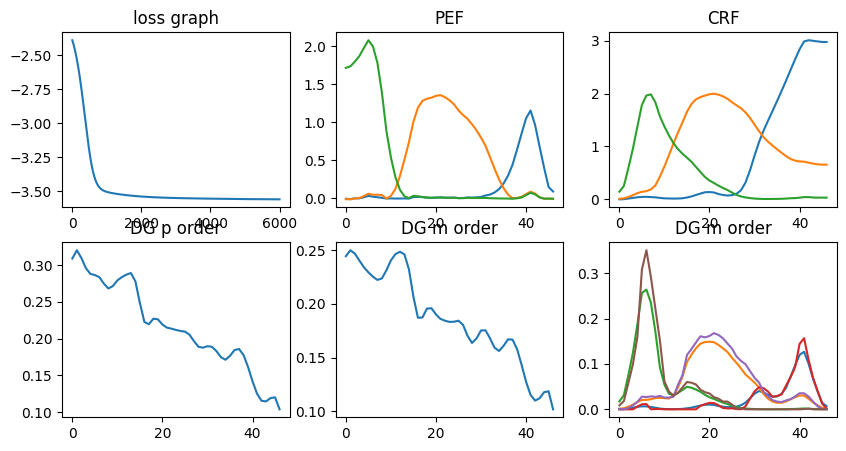

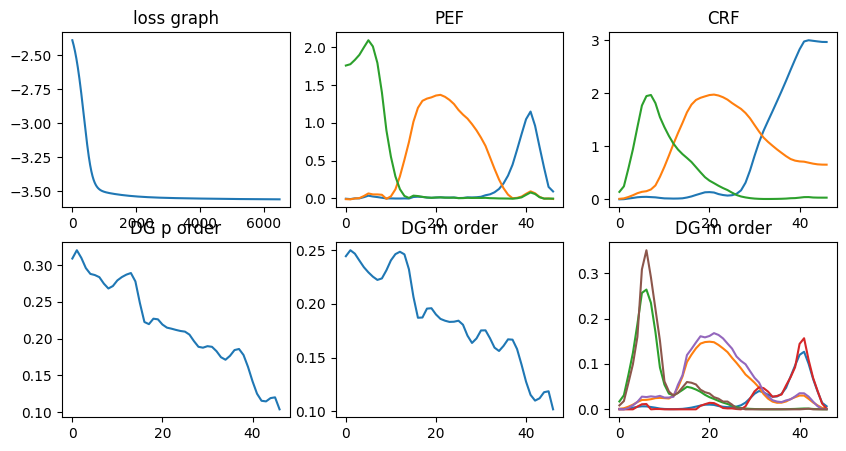

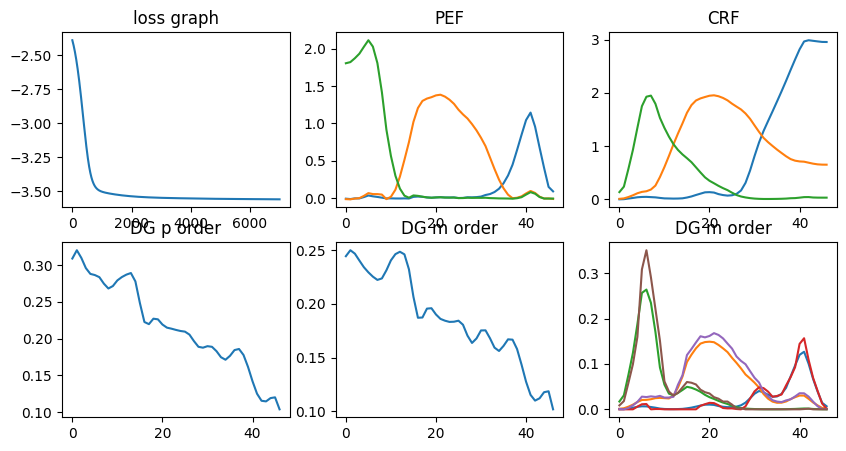

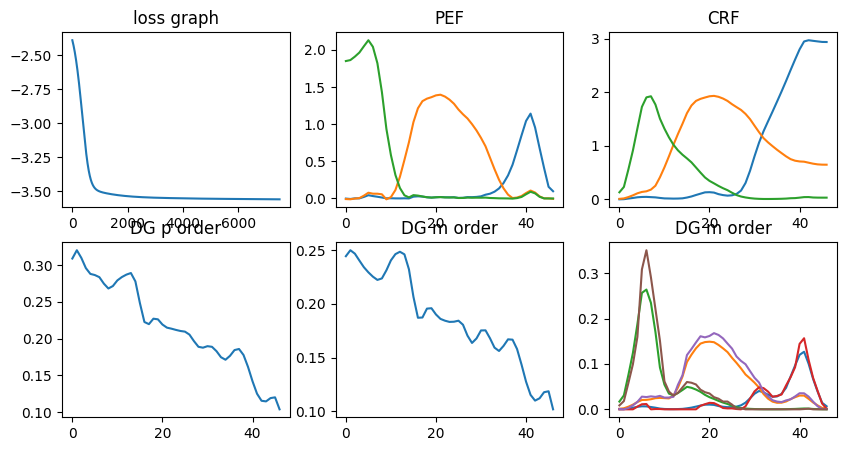

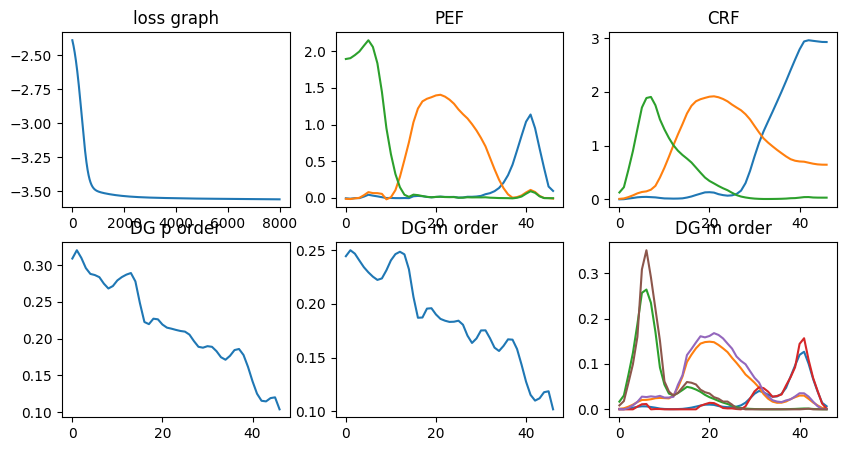

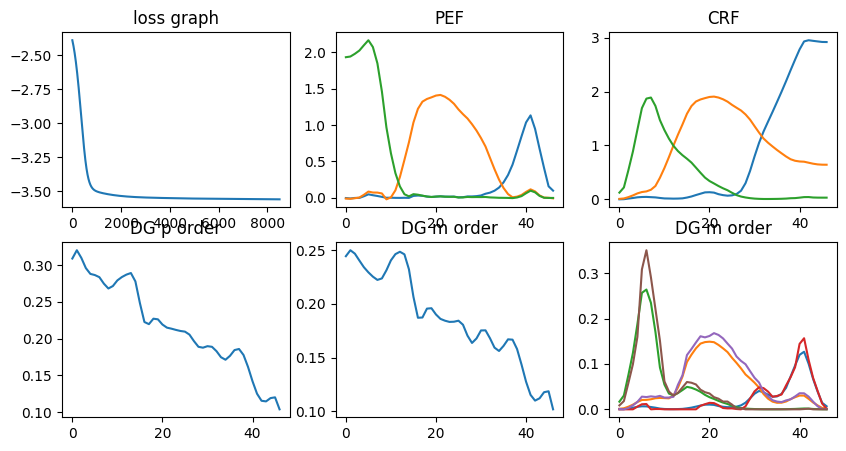

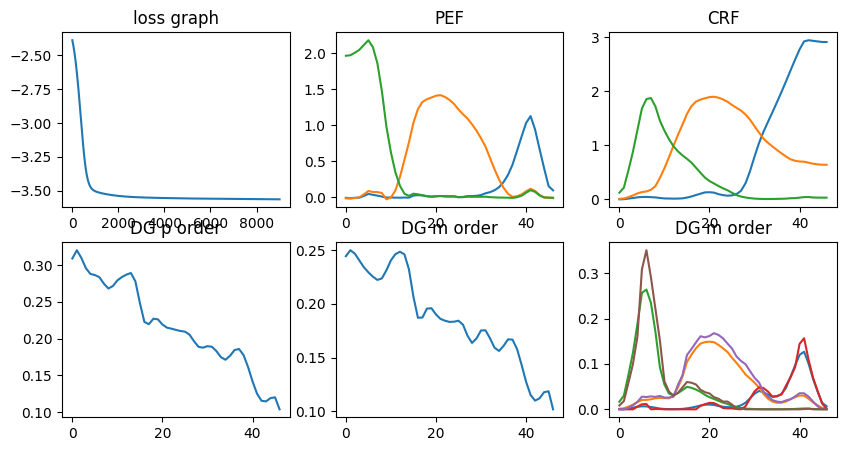

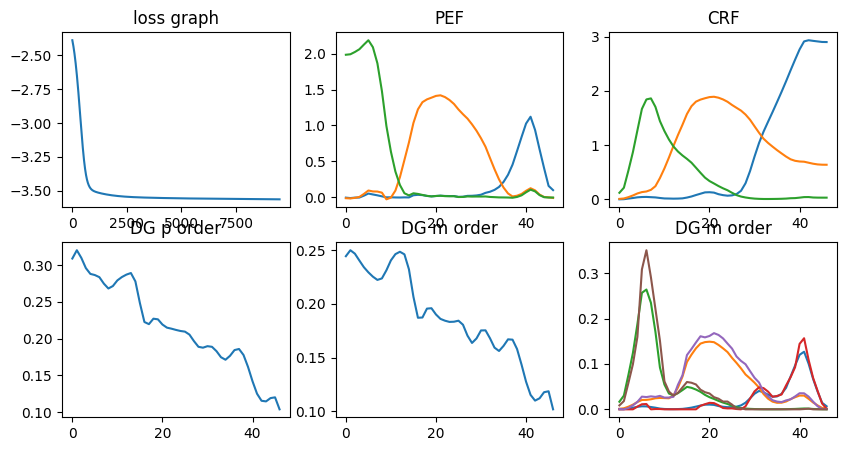

In [85]:
# arguments
device = 'cuda:0'
epoch = 10000
loss_f = torch.nn.MSELoss()
losses = [] 

# Height, width of image
H, W = 1, 1

# dg order
pfirst_patches = [0, 6, 12, 18, 1, 7, 13, 19]

# number of patches
num_patch = 24

# white pattern illuminated
white_pattern = torch.ones(size = (H, 3), device = device, dtype = torch.float)*0.8

# learning rate & decay step
lr = 0.003
decay_step = 5000
gamma = 0.5

# optimized paramter (CRF & PEF)
initial_value = torch.ones(size =(47, 6))
# initial_value = torch.ones(size =(47, 8))

opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# optimizer and schedular
optimizer = torch.optim.Adam([opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

# shape : 3, 47
PEF = torch.tensor(PEF_intp, dtype = torch.float).to(device).T
CRF = torch.tensor(CRF_intp, dtype = torch.float).to(device).T
dg_intensity = torch.tensor(dg_intensity_intp, dtype = torch.float).to(device).T
ref_CC = torch.tensor(ref_CC, dtype = torch.float).to(device)
patches_rgb_real_device = torch.tensor(patches_rgb_real, dtype = torch.float).to(device)
peak_illum_idx_final_device = torch.tensor(peak_illum_idx_final, dtype = torch.long).to(device)

opt_patch_idx = [random.randint(0,23) for i in range(15)] 
# opt_patch_idx = [0, 12, 13, 14, 16, 8]

for i in range(epoch):
    # initial loss
    loss = 0
    
    PEF_opt = opt_param[:,:3] * PEF
    CRF_opt = opt_param[:,3:] * CRF
    # CRF_opt = opt_param[:,3:-2] * CRF
    # dg_intensity_mfirst_opt = opt_param[:,-2] * dg_intensity[:,0]
    # dg_intensity_pfirst_opt = opt_param[:,-1] * dg_intensity[:,2]

    dg_intensity_mfirst_opt = dg_intensity[:,0]
    dg_intensity_pfirst_opt = dg_intensity[:,2]

    CRF_sum = CRF_opt.sum(axis = 1)
    
    # white pattern into multi-spectral channels
    white_pattern_hyp = white_pattern @ PEF_opt.T

    # loss for all patches
    for p in range(n_patches-3):
        if p in pfirst_patches:
            dg_efficiency = dg_intensity_pfirst_opt
        else:
            dg_efficiency = dg_intensity_mfirst_opt

        Simulated_I_RGB = ref_CC[:,p].unsqueeze(dim = 1) * CRF_opt * white_pattern_hyp.T * dg_efficiency.unsqueeze(dim = 1)
        GT_I_RGB = patches_rgb_real_device[peak_illum_idx_final_device[p], p]
                
        single_patch_loss = loss_f(Simulated_I_RGB, GT_I_RGB)
        loss += single_patch_loss.sum()
    
    CRF_dL2 = ((CRF_opt[:-1] - CRF_opt[1:])**2).sum()
    PEF_dL2 = ((PEF_opt[:-1] - PEF_opt[1:])**2).sum()
    # DGM_dL2 = ((dg_intensity_mfirst_opt[:-1] - dg_intensity_mfirst_opt[1:])**2).sum()
    # DGP_dL2 = ((dg_intensity_pfirst_opt[:-1] - dg_intensity_pfirst_opt[1:])**2).sum()
    
    weight = 0.0005
    loss += weight*(CRF_dL2 + PEF_dL2)
    # loss += weight*(CRF_dL2 + PEF_dL2 + DGM_dL2 + DGP_dL2)

    loss = loss.sum() 
    
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item() / (num_patch-2))

    optimizer.step()
    scheduler.step()
        
    if i % 500 == 0:
        print(f"Epoch : {i}/{epoch}, Loss: {loss.item() / (num_patch-2)}, LR: {optimizer.param_groups[0]['lr']}")

        opt_param_detach = opt_param.detach().cpu().numpy()
        Simulated_I_RGB_detach = Simulated_I_RGB.detach().cpu().numpy()
        GT_I_RGB_detach = GT_I_RGB.detach().cpu().numpy()
        
        np.save('./opt_params/opt_param_1021_detach_%05d.npy'%i, opt_param_detach)
        
        plt.figure(figsize = (10, 5))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.subplot(231), plt.plot([np.log10(loss) for loss in losses]), plt.title('loss graph')
        
        # CRF & PEF
        plt.subplot(232), plt.plot(PEF_opt.detach().cpu().numpy()), plt.title('PEF')
        plt.subplot(233), plt.plot(CRF_opt.detach().cpu().numpy()), plt.title('CRF')
        plt.subplot(234), plt.plot(dg_intensity_pfirst_opt.detach().cpu().numpy()), plt.title('DG p order')
        plt.subplot(235), plt.plot(dg_intensity_mfirst_opt.detach().cpu().numpy()), plt.title('DG m order')

        plt.subplot(236), plt.plot(Simulated_I_RGB_detach), plt.title('DG m order')
        plt.subplot(236), plt.plot(GT_I_RGB_detach), plt.title('DG m order')


#### PEF & CRF

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch : 0/10000, Loss: 0.030474738641218704, LR: 0.005
Epoch : 500/10000, Loss: 0.008218907497145912, LR: 0.005
Epoch : 1000/10000, Loss: 0.00798132067376917, LR: 0.005
Epoch : 1500/10000, Loss: 0.007975539700551466, LR: 0.005
Epoch : 2000/10000, Loss: 0.007975744252855127, LR: 0.0025
Epoch : 2500/10000, Loss: 0.007975462485443462, LR: 0.0025
Epoch : 3000/10000, Loss: 0.007975482805208727, LR: 0.0025
Epoch : 3500/10000, Loss: 0.007975408299402758, LR: 0.0025
Epoch : 4000/10000, Loss: 0.00797570835460316, LR: 0.00125
Epoch : 4500/10000, Loss: 0.007975180040706287, LR: 0.00125
Epoch : 5000/10000, Loss: 0.007975249805233696, LR: 0.00125
Epoch : 5500/10000, Loss: 0.007975171235474672, LR: 0.00125
Epoch : 6000/10000, Loss: 0.007975233549421484, LR: 0.000625
Epoch : 6500/10000, Loss: 0.007975035770372911, LR: 0.000625
Epoch : 7000/10000, Loss: 0.007975018159909681, LR: 0.000625
Epoch : 7500/10000, Loss: 0.007975062186067755, LR: 0.000625
Epoch : 8000/10000, Loss: 0.007975056767463684, LR: 0.

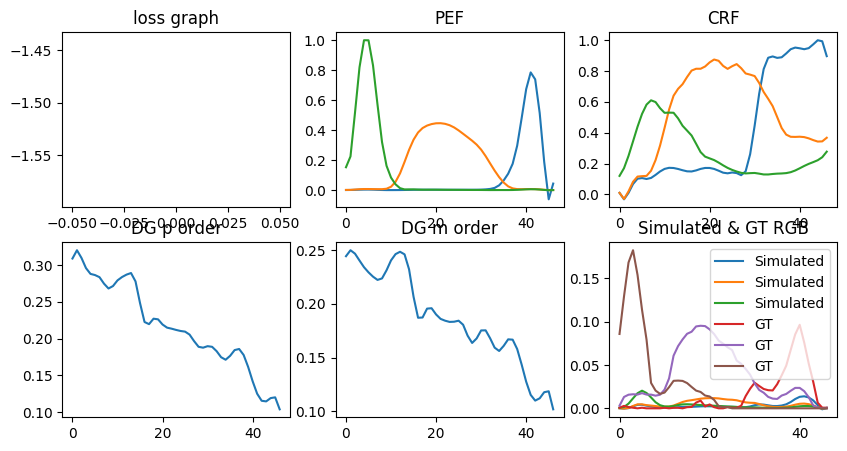

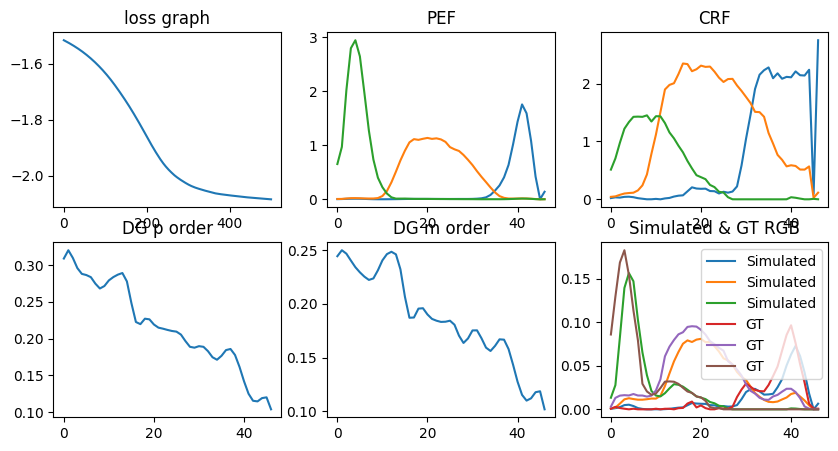

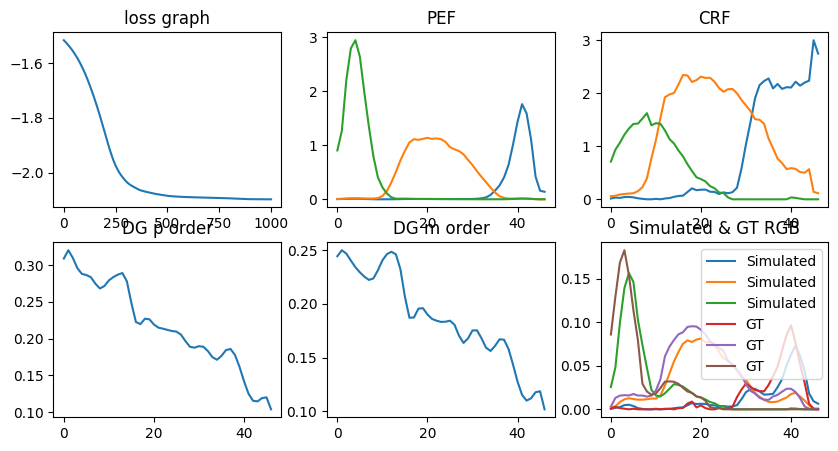

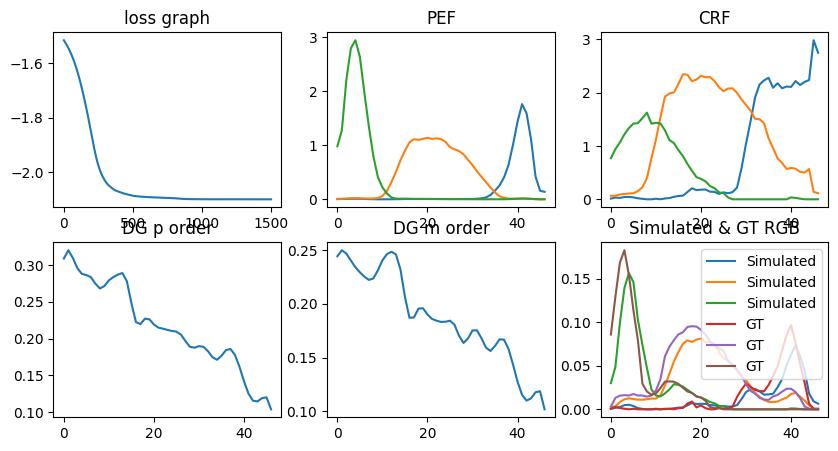

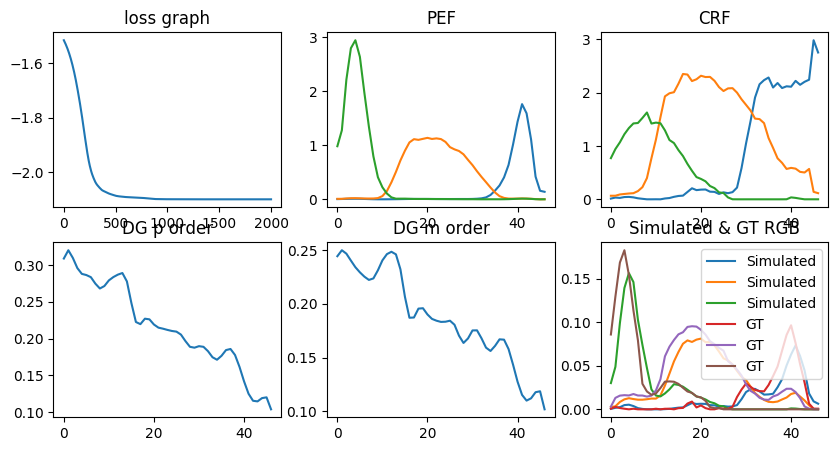

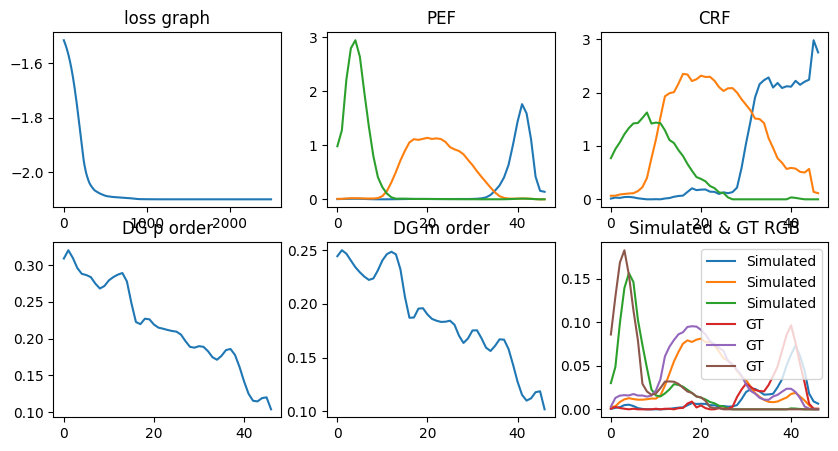

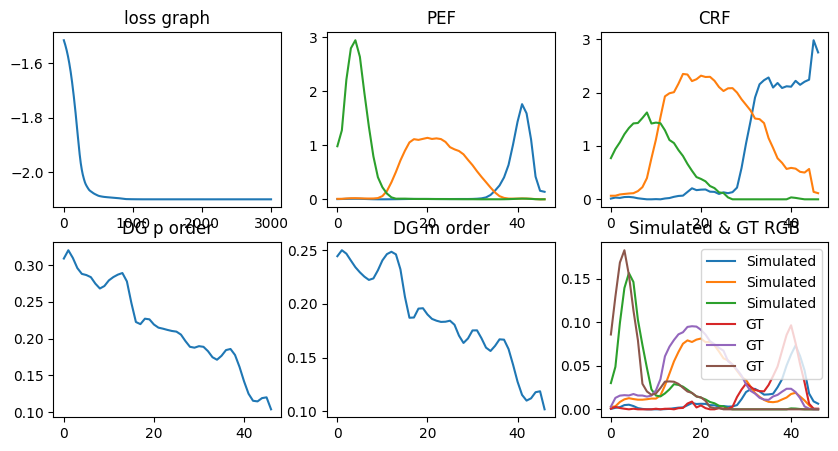

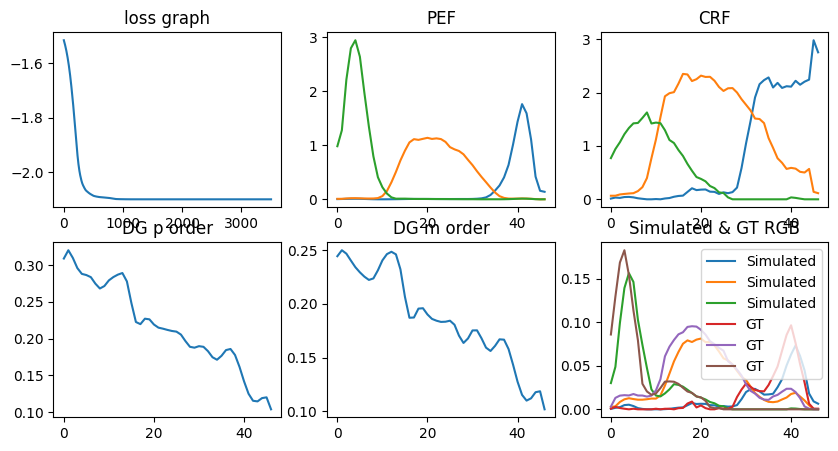

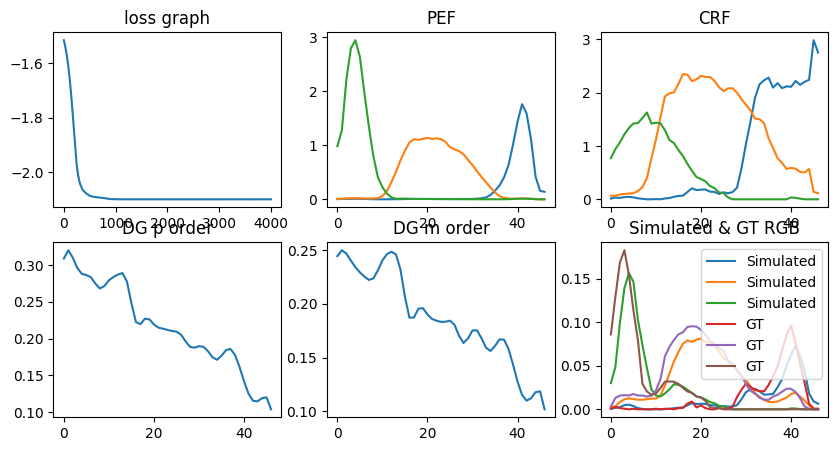

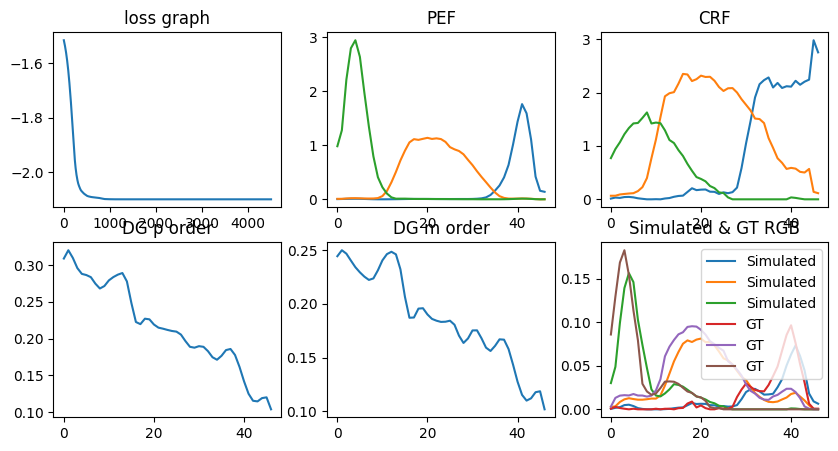

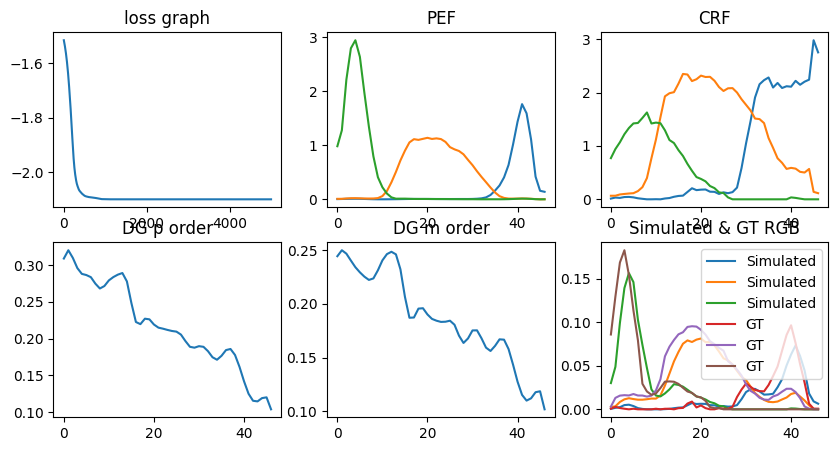

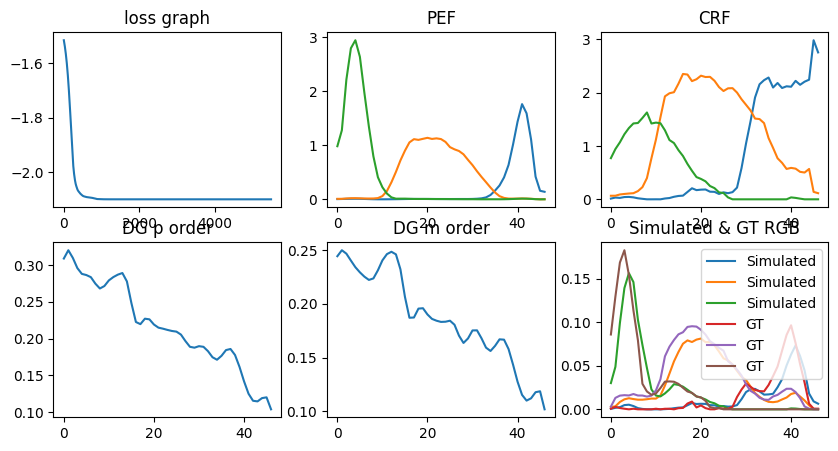

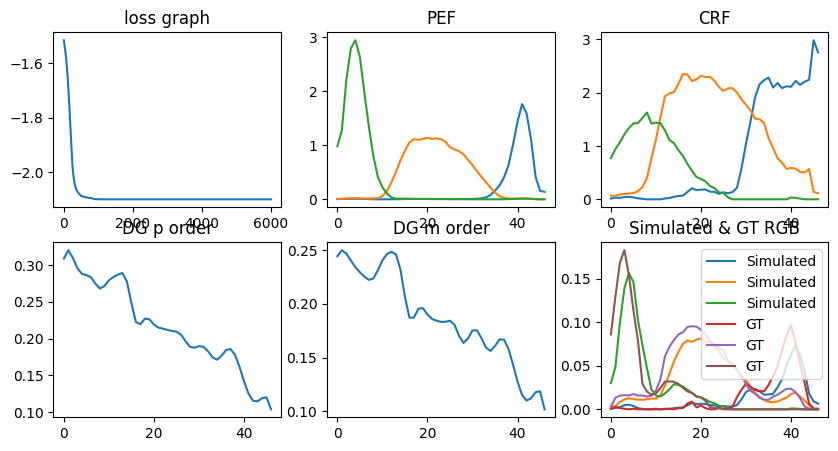

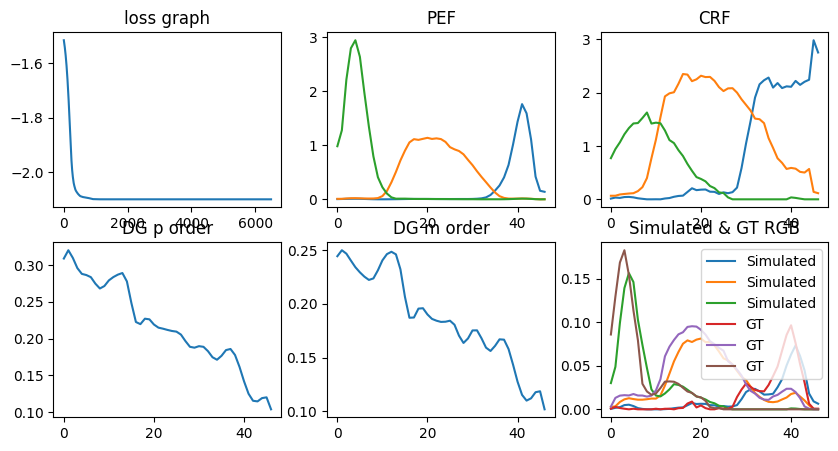

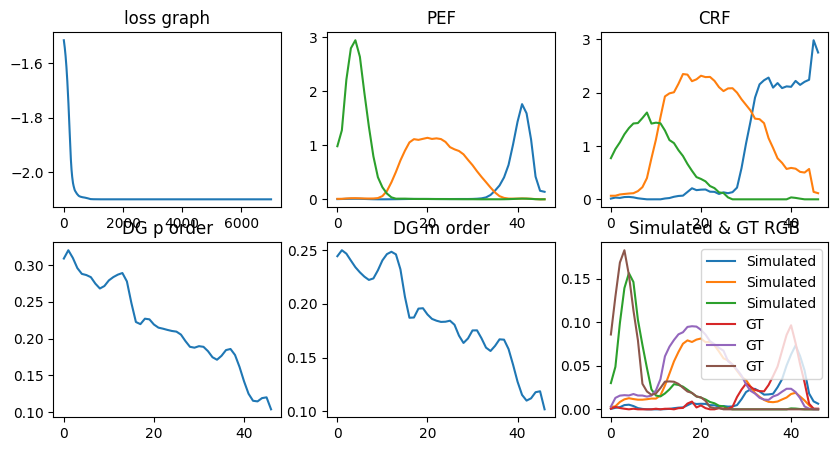

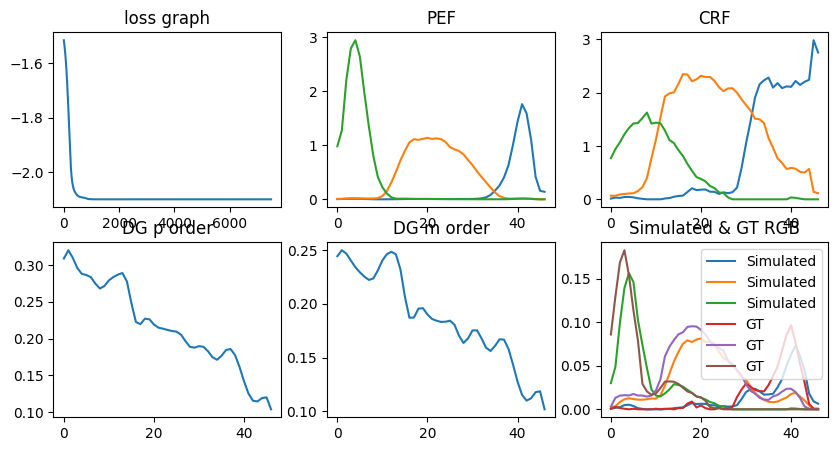

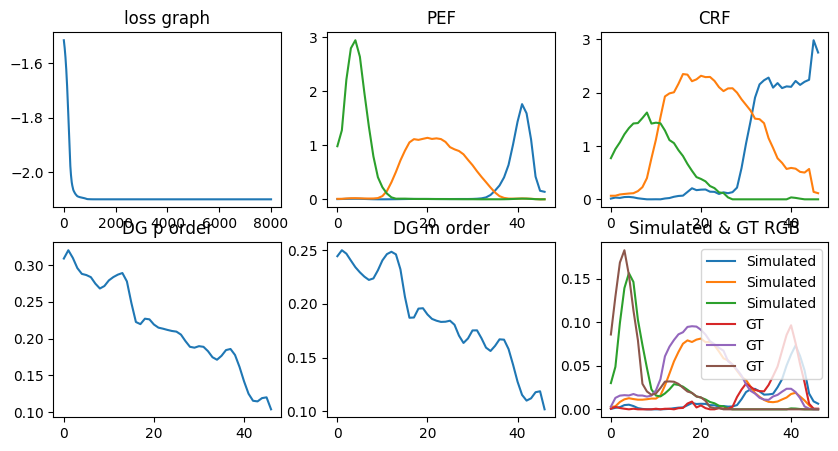

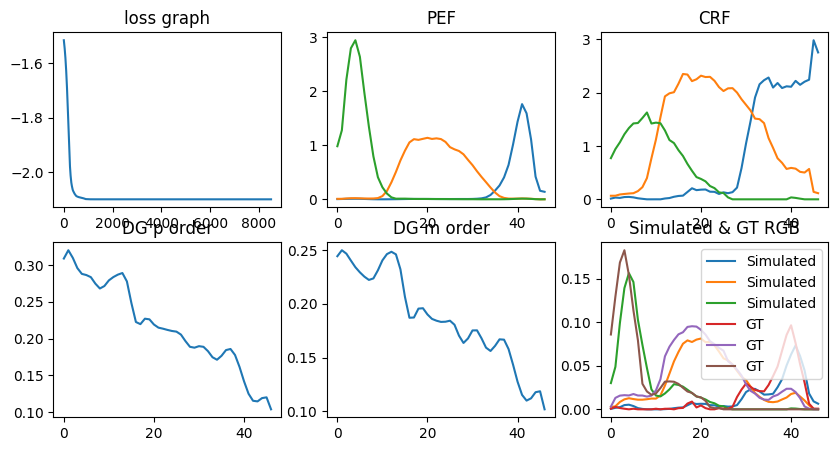

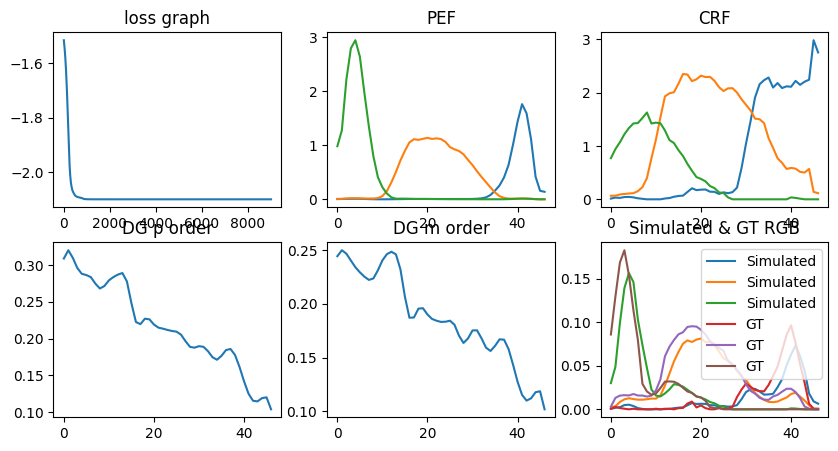

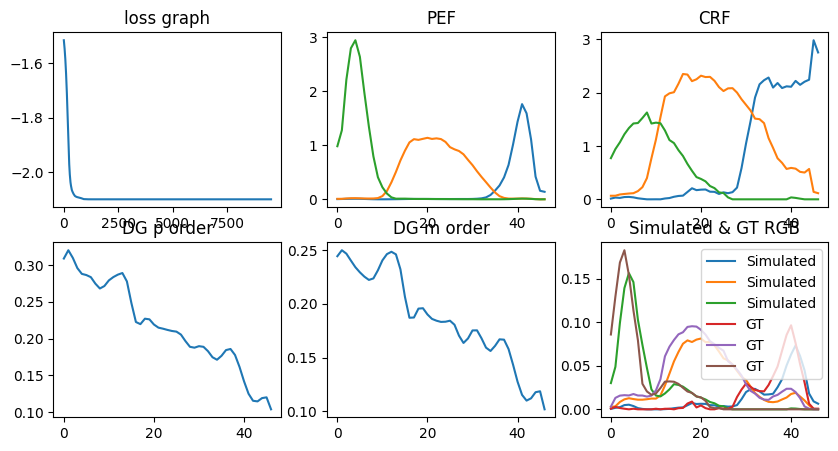

In [ ]:
# arguments
device = 'cuda:0'
epoch = 10000
loss_f = torch.nn.L1Loss()
losses = [] 

# Height, width of image
H, W = 1, 1

# dg order
pfirst_patches = [0, 6, 12, 18, 1, 7, 13, 19]

# number of patches
num_patch = 24

# white pattern illuminated
white_pattern = torch.ones(size = (H, 3), device = device, dtype = torch.float)*0.8

# learning rate & decay step
lr = 0.005
decay_step = 2000
gamma = 0.5

# optimized paramter (CRF & PEF)
initial_value = torch.ones(size =(47, 6))

opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# optimizer and schedular
optimizer = torch.optim.Adam([opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

# shape : 3, 47
PEF = torch.tensor(PEF_intp, dtype = torch.float).to(device).T
CRF = torch.tensor(CRF_intp, dtype = torch.float).to(device).T
dg_intensity = torch.tensor(dg_intensity_intp, dtype = torch.float).to(device).T
ref_CC = torch.tensor(ref_CC, dtype = torch.float).to(device)
patches_rgb_real_detach = torch.tensor(patches_rgb_real, dtype = torch.float).to(device)
peak_illum_idx_final_detach = torch.tensor(peak_illum_idx_final, dtype = torch.long).to(device)

opt_patch_idx = [18, 8]

for i in range(epoch):
    # initial loss
    loss = 0
    
    PEF_opt = opt_param[:,:3] * PEF
    CRF_opt = opt_param[:,3:] * CRF
    dg_intensity_mfirst_opt = dg_intensity[:,0]
    dg_intensity_pfirst_opt = dg_intensity[:,2]

    CRF_sum = CRF_opt.sum(axis = 1)
    
    # white pattern into multi-spectral channels
    white_pattern_hyp = white_pattern @ PEF_opt.T

    # loss for all patches
    # for p in opt_patch_idx:
    for p in range(n_patches-2):
        if p in pfirst_patches:
            dg_efficiency = dg_intensity_pfirst_opt
        else:
            dg_efficiency = dg_intensity_mfirst_opt

        Simulated_I_RGB = ref_CC[:,p].unsqueeze(dim = 1) * CRF_opt * white_pattern_hyp.T * dg_efficiency.unsqueeze(dim = 1)
        GT_I_RGB = patches_rgb_real_detach[peak_illum_idx_final_detach[p], p]
                
        single_patch_loss = loss_f(Simulated_I_RGB, GT_I_RGB)
        loss += single_patch_loss.sum()
    
    CRF_dL2 = ((CRF_opt[:-1] - CRF_opt[1:])**2).sum()
    PEF_dL2 = ((PEF_opt[:-1] - PEF_opt[1:])**2).sum()
   
    weight = 0.05
    # loss += weight*(CRF_dL2 + PEF_dL2)
    loss = loss.sum()
    
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item() / (num_patch-2))
    optimizer.step()
    scheduler.step()
        
    if i % 500 == 0:
        print(f"Epoch : {i}/{epoch}, Loss: {loss.item() / (num_patch-2)}, LR: {optimizer.param_groups[0]['lr']}")

        opt_param_detach = opt_param.detach().cpu().numpy()
        Simulated_I_RGB_detach = Simulated_I_RGB.detach().cpu().numpy()
        GT_I_RGB_detach = GT_I_RGB.detach().cpu().numpy()
        
        np.save('./opt_params/opt_param_0915_detach_%05d.npy'%i, opt_param_detach)
        
        plt.figure(figsize = (10, 5))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.subplot(231), plt.plot([np.log10(loss) for loss in losses]), plt.title('loss graph')
        
        # CRF & PEF
        plt.subplot(232), plt.plot(PEF_opt.detach().cpu().numpy()), plt.title('PEF')
        plt.subplot(233), plt.plot(CRF_opt.detach().cpu().numpy()), plt.title('CRF')
        plt.subplot(234), plt.plot(dg_intensity_pfirst_opt.detach().cpu().numpy()), plt.title('DG p order')
        plt.subplot(235), plt.plot(dg_intensity_mfirst_opt.detach().cpu().numpy()), plt.title('DG m order')

        plt.subplot(236), plt.plot(Simulated_I_RGB_detach, label = 'Simulated'), plt.title('Simulated & GT RGB')
        plt.subplot(236), plt.plot(GT_I_RGB_detach, label = 'GT')
        plt.legend()

### PEF, CRF, DG Optimization with 0-order

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:27: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:37: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).


Epoch : 0/10000, Loss: 0.008376939730210737, LR: 0.05
Epoch : 500/10000, Loss: 0.0002571852793070403, LR: 0.05
Epoch : 1000/10000, Loss: 0.0002571852793070403, LR: 0.05
Epoch : 1500/10000, Loss: 0.0002571852793070403, LR: 0.05
Epoch : 2000/10000, Loss: 0.00025718530047346246, LR: 0.05
Epoch : 2500/10000, Loss: 0.0002571852793070403, LR: 0.05
Epoch : 3000/10000, Loss: 0.0002571852793070403, LR: 0.05
Epoch : 3500/10000, Loss: 0.0002571852793070403, LR: 0.05
Epoch : 4000/10000, Loss: 0.00025718530047346246, LR: 0.05
Epoch : 4500/10000, Loss: 0.00025718530047346246, LR: 0.05
Epoch : 5000/10000, Loss: 0.00025718530047346246, LR: 0.025


KeyboardInterrupt: 

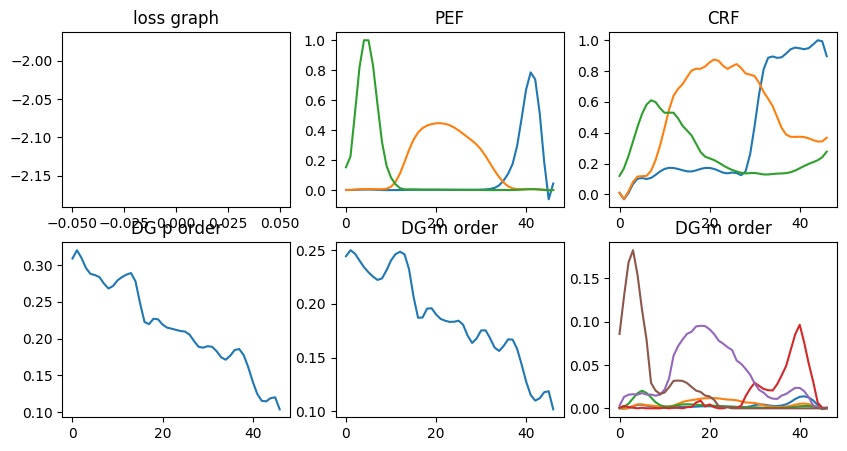

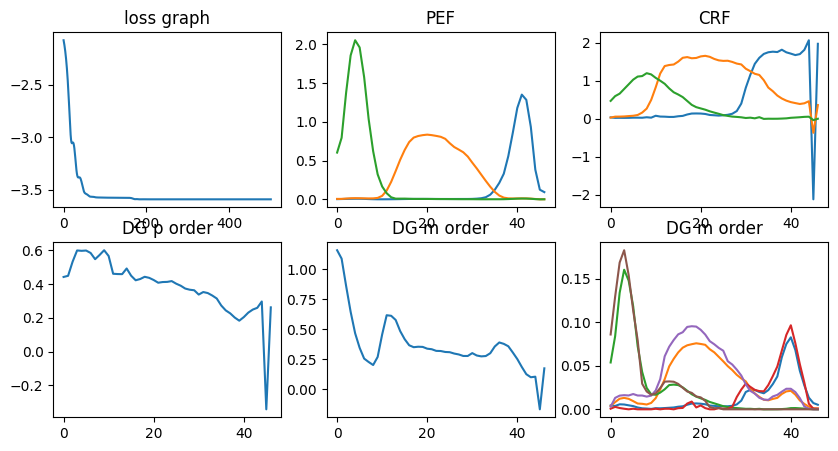

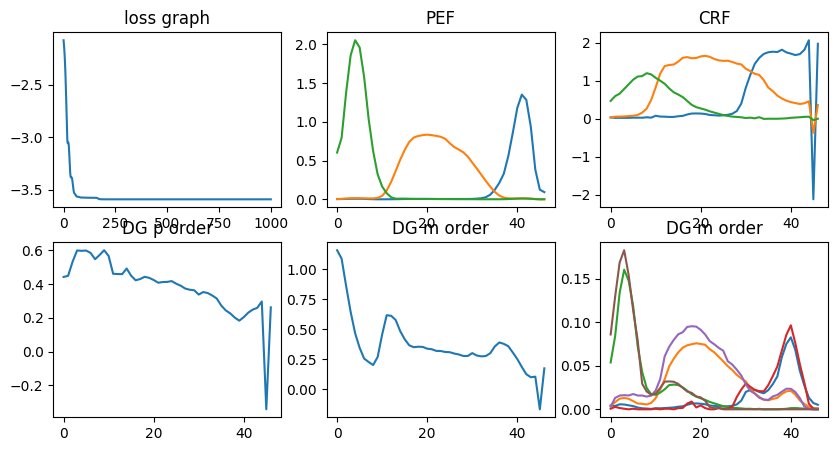

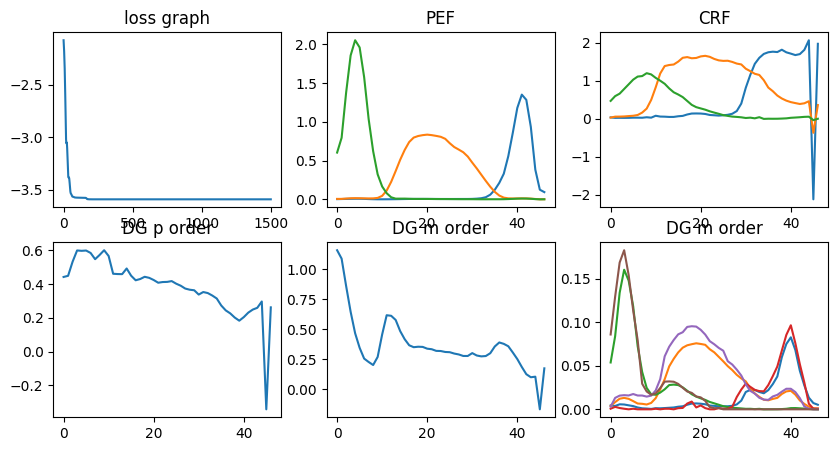

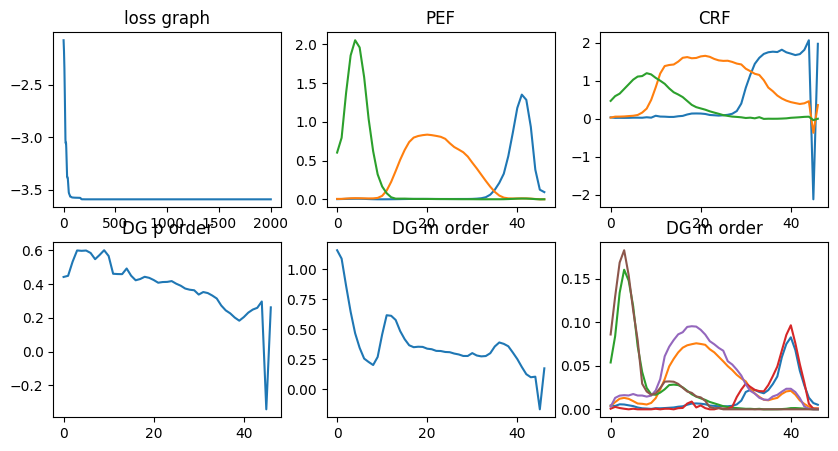

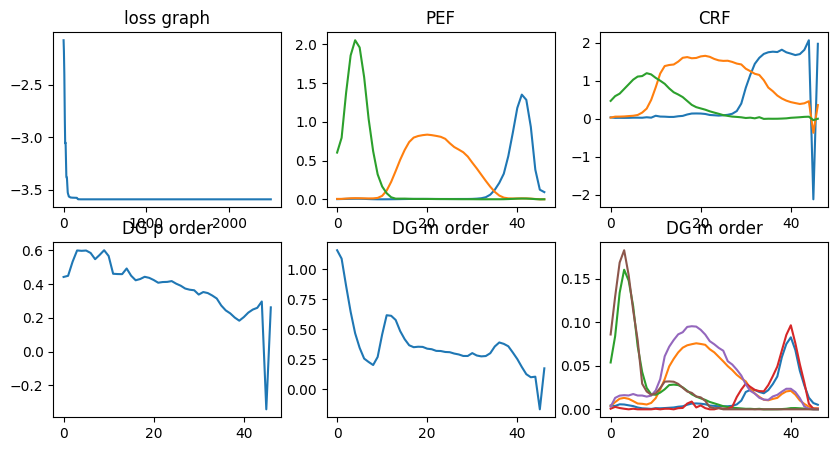

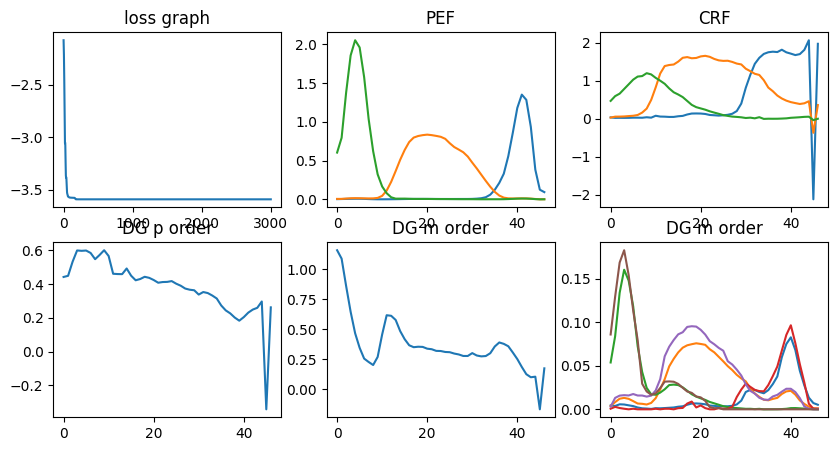

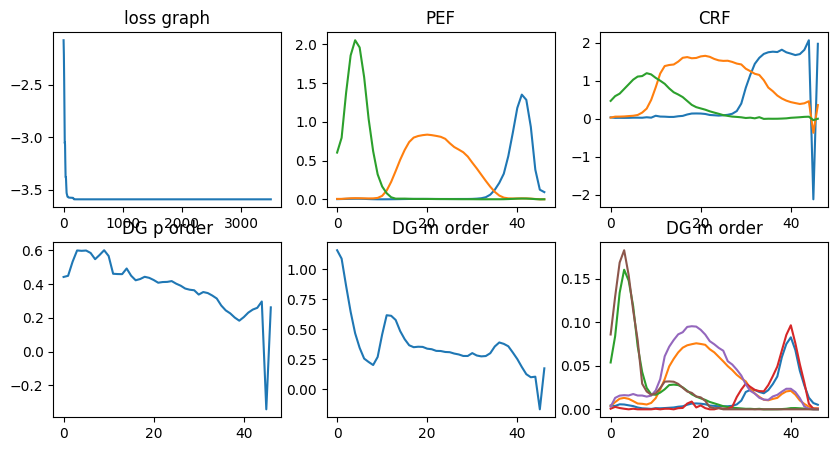

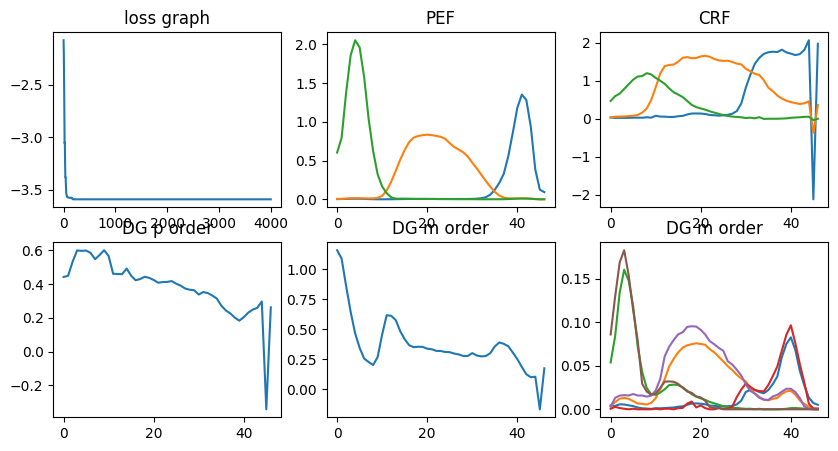

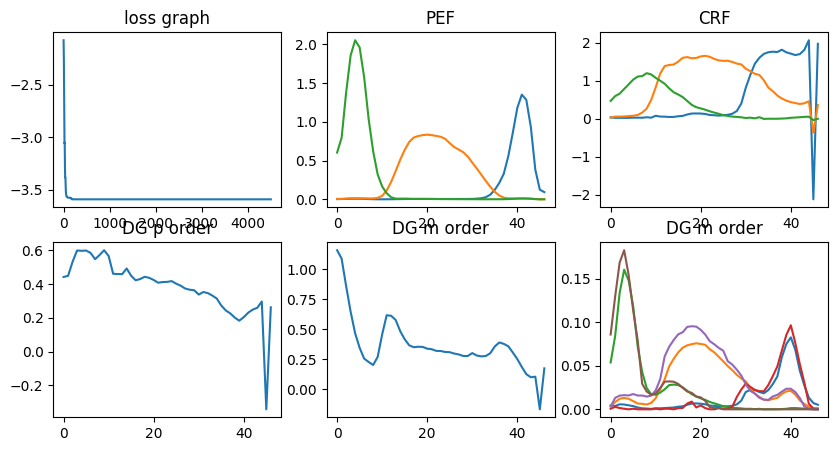

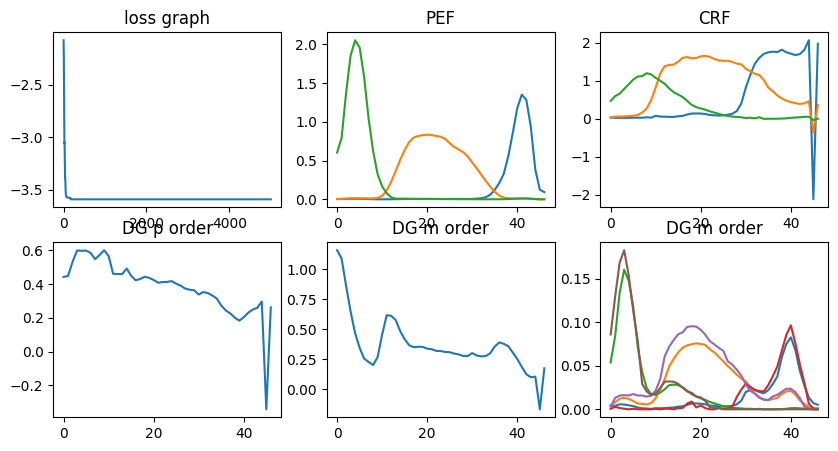

In [ ]:
# arguments
device = 'cuda:0'
epoch = 10000
loss_f = torch.nn.MSELoss()
losses = [] 

# Height, width of image
H, W = 1, 1

# dg order
pfirst_patches = [0, 6, 12, 18, 1, 7, 13, 19]

# number of patches
num_patch = 24

# white pattern illuminated
white_pattern = torch.ones(size = (H, 3), device = device, dtype = torch.float)*0.8

# learning rate & decay step
lr = 0.05
decay_step = 5000
gamma = 0.5

# optimized paramter (CRF & PEF)
initial_value = torch.ones(size =(47, 8))

opt_param =  torch.tensor(initial_value, dtype= torch.float, requires_grad=True, device= device)

# optimizer and schedular
optimizer = torch.optim.Adam([opt_param], lr = lr)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=decay_step, gamma = gamma)

# shape : 3, 47
PEF = torch.tensor(PEF_intp, dtype = torch.float).to(device).T
CRF = torch.tensor(CRF_intp, dtype = torch.float).to(device).T
dg_intensity = torch.tensor(dg_intensity_intp, dtype = torch.float).to(device).T
ref_CC = torch.tensor(ref_CC, dtype = torch.float).to(device)
patches_rgb_real_device = torch.tensor(patches_rgb_real, dtype = torch.float).to(device)
peak_illum_idx_final_device = torch.tensor(peak_illum_idx_final, dtype = torch.long).to(device)
rgb_correction = torch.tensor([0.04095889, 0.04477243, 0.04151389], device=device)
zero_illum_idx_final_device = torch.tensor(zero_illum_idx_final, dtype = torch.long).to(device)

opt_patch_idx = [random.randint(0,23) for i in range(15)] 
# opt_patch_idx = [0, 12, 13, 14, 16, 8]

for i in range(epoch):
    # initial loss
    loss = 0
    
    PEF_opt = opt_param[:,:3] * PEF
    CRF_opt = opt_param[:,3:-2] * CRF
    dg_intensity_mfirst_opt = opt_param[:,-2] * dg_intensity[:,0]
    dg_intensity_pfirst_opt = opt_param[:,-1] * dg_intensity[:,2]

    CRF_sum = CRF_opt.sum(axis = 1)
    
    # white pattern into multi-spectral channels
    white_pattern_hyp = white_pattern @ PEF_opt.T

    # loss for all patches
    # for p in opt_patch_idx:
    for p in range(n_patches-2):
        if p in pfirst_patches:
            dg_efficiency = dg_intensity_pfirst_opt
        else:
            dg_efficiency = dg_intensity_mfirst_opt

        # first order
        Simulated_I_RGB = ref_CC[:,p].unsqueeze(dim = 1) * CRF_opt * white_pattern_hyp.T * dg_efficiency.unsqueeze(dim = 1)
        GT_I_RGB = patches_rgb_real_device[peak_illum_idx_final_device[p], p]
        
        # zero order
        Simulated_Zero_RGB = (ref_CC[:,p].unsqueeze(dim = 0) * white_pattern_hyp) @ CRF_opt
        # GT_Zero_RGB = patches_rgb_real_device[zero_illum_idx_final_device[p,0], p] * rgb_correction

        single_patch_loss = loss_f(Simulated_I_RGB, GT_I_RGB)
        # zero_patch_loss = loss_f(Simulated_Zero_RGB.squeeze(), GT_Zero_RGB)
        
        loss = loss + single_patch_loss.sum() + zero_patch_loss.sum()
        # loss += single_patch_loss.sum()

    # CRF_dL2 = ((CRF_opt[:-1] - CRF_opt[1:])**2).sum()
    # PEF_dL2 = ((PEF_opt[:-1] - PEF_opt[1:])**2).sum()
    # DGM_dL2 = ((dg_intensity_mfirst_opt[:-1] - dg_intensity_mfirst_opt[1:])**2).sum()
    # DGP_dL2 = ((dg_intensity_pfirst_opt[:-1] - dg_intensity_pfirst_opt[1:])**2).sum()
    
    # weight = 0.0005
    # loss += weight*(CRF_dL2 + PEF_dL2 + DGM_dL2 + DGP_dL2)
    loss = loss.sum() * 10
    
    optimizer.zero_grad()
    loss.backward()
    losses.append(loss.item() / (num_patch-2)*2)
    # losses.append(loss.item() / len(opt_patch_idx))

    optimizer.step()
    scheduler.step()
        
    if i % 500 == 0:
        print(f"Epoch : {i}/{epoch}, Loss: {loss.item() / (num_patch-2)*2}, LR: {optimizer.param_groups[0]['lr']}")
        # print(f"Epoch : {i}/{epoch}, Loss: {loss.item() / len(opt_patch_idx)}, LR: {optimizer.param_groups[0]['lr']}")

        opt_param_detach = opt_param.detach().cpu().numpy()
        Simulated_I_RGB_detach = Simulated_I_RGB.detach().cpu().numpy()
        GT_I_RGB_detach = GT_I_RGB.detach().cpu().numpy()
        
        np.save('./opt_params/opt_param_0915_detach_%05d.npy'%i, opt_param_detach)
        
        plt.figure(figsize = (10, 5))
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.subplot(231), plt.plot([np.log10(loss) for loss in losses]), plt.title('loss graph')
        
        # CRF & PEF
        plt.subplot(232), plt.plot(PEF_opt.detach().cpu().numpy()), plt.title('PEF')
        plt.subplot(233), plt.plot(CRF_opt.detach().cpu().numpy()), plt.title('CRF')
        plt.subplot(234), plt.plot(dg_intensity_pfirst_opt.detach().cpu().numpy()), plt.title('DG p order')
        plt.subplot(235), plt.plot(dg_intensity_mfirst_opt.detach().cpu().numpy()), plt.title('DG m order')

        plt.subplot(236), plt.plot(Simulated_I_RGB_detach), plt.title('DG m order')
        plt.subplot(236), plt.plot(GT_I_RGB_detach), plt.title('DG m order')


### Optimized Result

In [ ]:
# bring optimized parameters
opt_param_final = np.load('./opt_params/opt_param_1021_detach_03000.npy')

# detach
ref_CC_detach = ref_CC.detach().cpu().numpy()
patches_rgb_real_detach = patches_rgb_real
peak_illum_idx_final_detach = peak_illum_idx_final

# update parameter
# CRF_intp_update = CRF_intp.T * opt_param_final[:,3:-2]
CRF_intp_update = CRF_intp.T * opt_param_final[:,3:]

PEF_intp_update = PEF_intp.T * opt_param_final[:,:3]

In [ ]:
# white pattern
white_patt = np.ones(shape = (1, 3)) * 0.8
white_patt_hyp = white_patt @  PEF_intp_update.T
white_patt_hyp = white_patt_hyp.squeeze()

In [ ]:
# test with GT reflectance for all patches
total_patch_update = []
for p in range(n_patches):
    if p in pfirst_patches:
        dg_eff = dg_intensity_intp[2] #* opt_param_final[:,-1]
    else:
        dg_eff = dg_intensity_intp[0] #* opt_param_final[:,-2]

    I_C = ref_CC_detach[:,p][:,np.newaxis] * CRF_intp_update * white_patt_hyp[:,np.newaxis] * dg_eff[:,np.newaxis] 

    total_patch_update.append(I_C)
total_patch_update = np.array(total_patch_update)

c:\Users\owner\anaconda3\envs\hyper3d\lib\site-packages\ipykernel_launcher.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  import sys


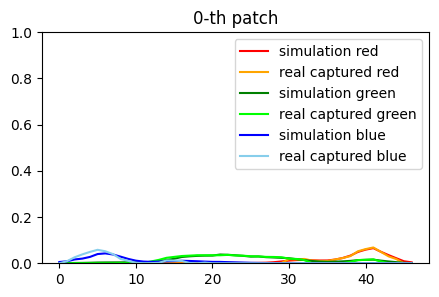

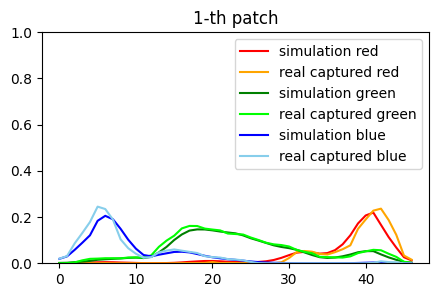

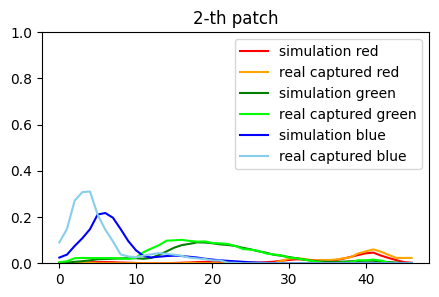

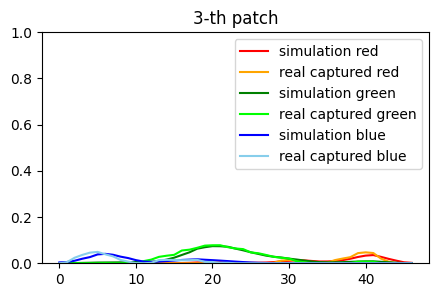

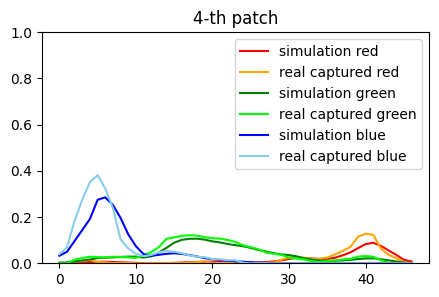

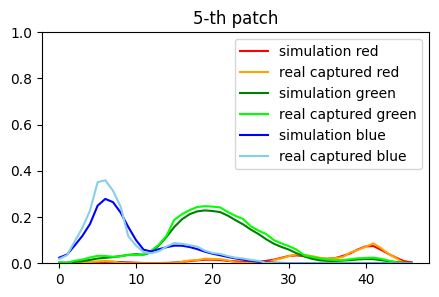

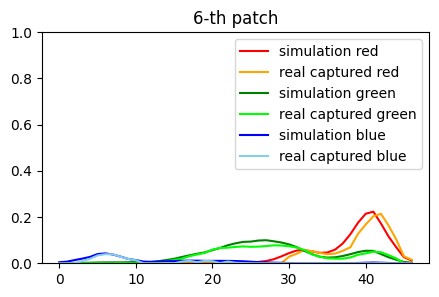

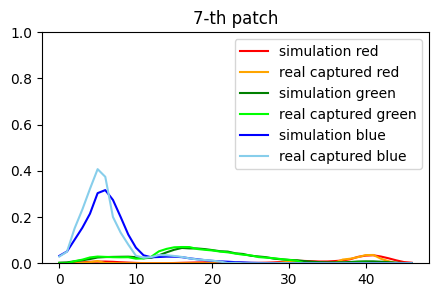

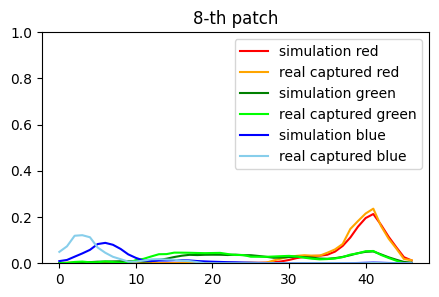

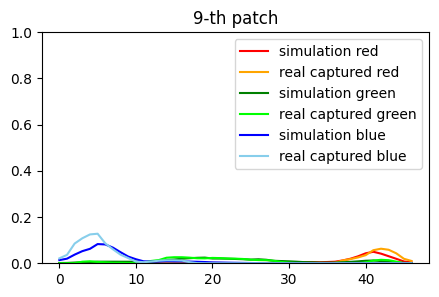

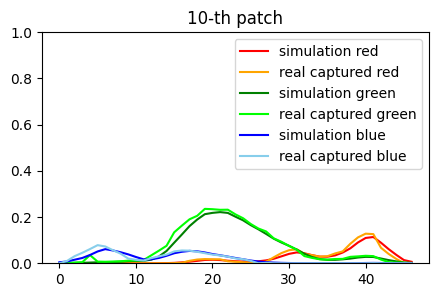

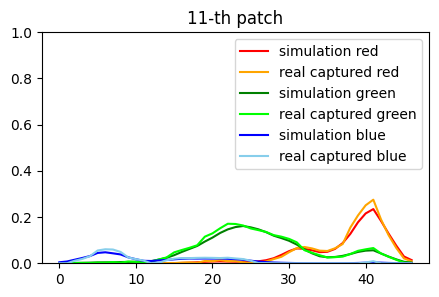

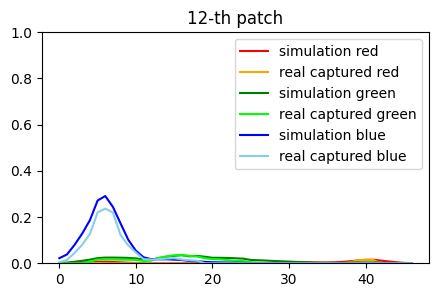

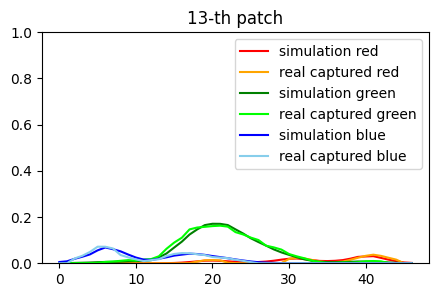

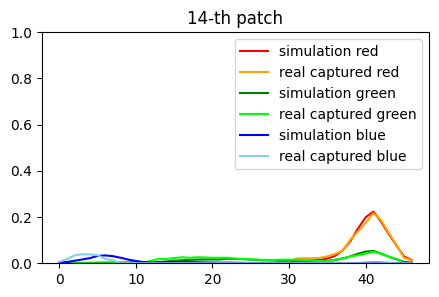

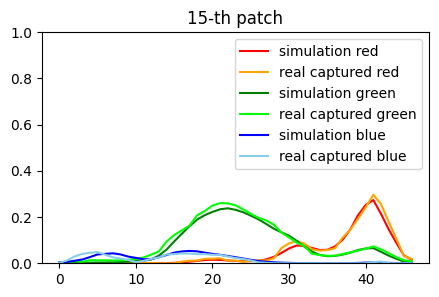

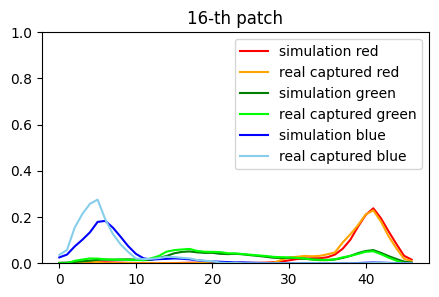

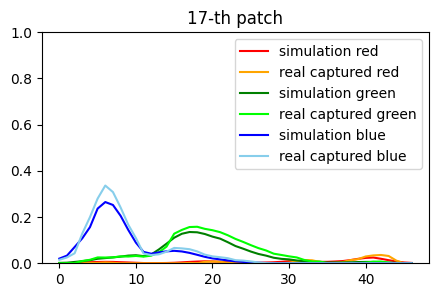

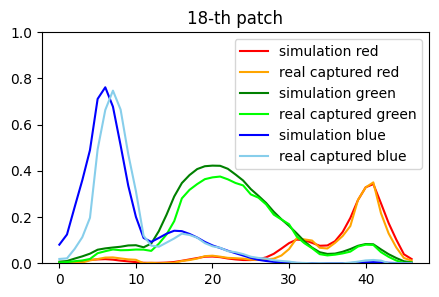

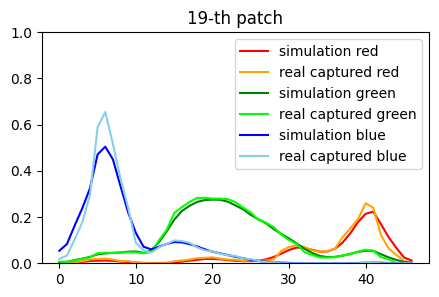

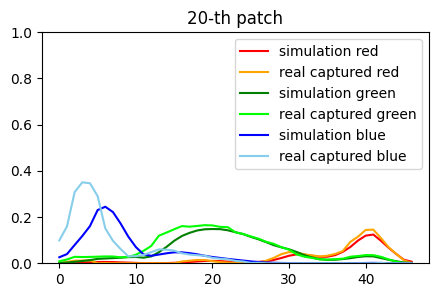

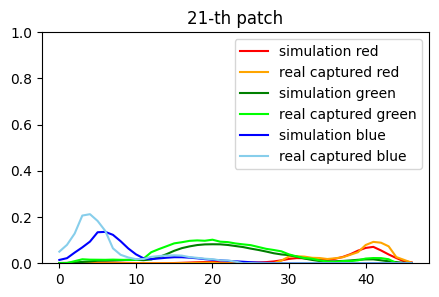

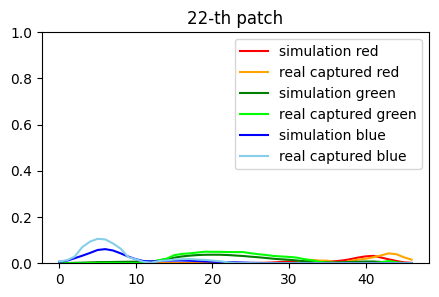

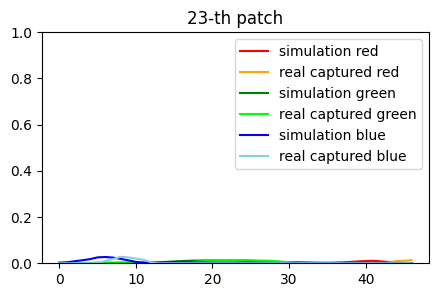

In [ ]:
constant = 1
max_ylim = 0.9
patch_num = 12

# plot 1st order rgb intensity for all patches
for p in range(n_patches): # only visualize white patch
    plt.figure(figsize=(5,3))
    plt.ylim([0, 1])    
    
    # red
    plt.plot(total_patch_update[p][:,0] * constant, c = 'red', label = 'simulation red')
    plt.plot(patches_rgb_real_detach[peak_illum_idx_final_detach[p], p][:,0], c = 'orange', label = 'real captured red')
    plt.legend()

    # green
    plt.plot(total_patch_update[p][:,1]* constant, c = 'green', label = 'simulation green')
    plt.plot(patches_rgb_real_detach[peak_illum_idx_final_detach[p], p][:,1], c = 'lime', label = 'real captured green')
    plt.legend()
    
    # blue
    plt.plot(total_patch_update[p][:,2]* constant, c = 'blue', label = 'simulation blue')
    plt.plot(patches_rgb_real_detach[peak_illum_idx_final_detach[p], p][:,2], c = 'skyblue', label = 'real captured blue')
    
    plt.title('%s-th patch'%p)
    # plt.savefig('%s-th patch rgb intensity GT vs Simulation'%p)
    plt.legend()